## ANN Model for loan prediction

You can download the database from
https://drive.google.com/file/d/1kEc4eXsmvZW-8gmL3q7l6T_bGKjUAM85/view?usp=sharing
It's almost more then 150 mb dataset

Steps to be done: 

1. Load the dataset that is given to you
2. Check for null values in the dataset
3. Print percentage of default to payer of the dataset for the TARGET column
4. Balance the dataset if the data is imbalanced
5. Plot the balanced data or imbalanced data
6. Encode the columns that is required for the model
7. Calculate Sensitivity as a metrice
8. Calculate area under receiver operating characteristics curve

Used Keras and Keras Tuner (for selecting hidden layers and neural networks)

In [1]:
import pandas as pd
import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1. Load the dataset that is given to you

In [2]:
loan_df = pd.read_csv('loan_data.csv')

## 2. Check for null values in the dataset

In [3]:
loan_df.isnull().sum().sum()

9152465

## 3. Print percentage of default to payer of the dataset for the TARGET column

In [4]:
print(f"percentage of defaulters in dataset : {(loan_df['TARGET'][loan_df['TARGET'] == 1].count()/loan_df.shape[0])*100}")

percentage of defaulters in dataset : 8.072881945686495


# Data Preprocessing

In [5]:
loan_df.shape

(307511, 122)

In [6]:
# Removing irrelivent feature
loan_df.drop('SK_ID_CURR', axis=1, inplace=True)

Dividing dataset into numerical and categorical features

In [7]:
num_col = loan_df.select_dtypes(exclude = ['object']).columns
cat_col = loan_df.select_dtypes(include = ['object']).columns

### Handling missing values of categorical features

In [8]:
# checking for null values
loan_df[cat_col].isnull().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [9]:
null_cat_col = loan_df[cat_col].loc[:,(loan_df[cat_col].isnull().sum()>0)].columns
null_cat_col

Index(['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [10]:
null_cat_col = loan_df[cat_col].loc[:,loan_df[cat_col].isnull().sum()>0].columns
null_cat_col

Index(['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [11]:
loan_df[null_cat_col].isnull().sum()/loan_df.shape[0]

NAME_TYPE_SUITE        0.004201
OCCUPATION_TYPE        0.313455
FONDKAPREMONT_MODE     0.683862
HOUSETYPE_MODE         0.501761
WALLSMATERIAL_MODE     0.508408
EMERGENCYSTATE_MODE    0.473983
dtype: float64

### Impute categorical null values with Random Sample Imputer for missing data < 50%

In [12]:
rsi_cols = loan_df[null_cat_col].loc[:,loan_df[null_cat_col].isnull().sum()/loan_df.shape[0]<0.50].columns
rsi_cols

Index(['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'EMERGENCYSTATE_MODE'], dtype='object')

In [13]:
for col in rsi_cols:
    samples = loan_df[col].dropna().sample(loan_df[col].isnull().sum())
    samples.index = loan_df[col][loan_df[col].isnull()].index
    loan_df[col][loan_df[col].isnull()] = samples

<ipython-input-13-83ad885c16fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col][loan_df[col].isnull()] = samples


In [14]:
null_cat_col = loan_df[cat_col].loc[:,loan_df[cat_col].isnull().sum()>0].columns
null_cat_col

Index(['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'], dtype='object')

### Impute categorical null values with mode for missing values > 50%

In [15]:
for col in null_cat_col:
    loan_df[col].fillna(loan_df[col].mode()[0], inplace=True)

In [16]:
loan_df[cat_col].isnull().sum().sum()

0

## Handling missing values of Numerical Features

In [17]:
null_num_col = loan_df[num_col].loc[:,(loan_df[num_col].isnull().sum()>0)].columns

In [18]:
# missing data in percentage
loan_df[null_num_col].isnull().sum()

AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
OWN_CAR_AGE                   202929
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  173378
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 61, dtype: int64

### Spliting into < 50% and >=50% missing data

In [19]:
less_50 = loan_df[null_num_col].loc[:,loan_df[null_num_col].isnull().sum()/loan_df[null_num_col].shape[0] < 0.50].columns
gr_eq_50 = loan_df[null_num_col].loc[:,loan_df[null_num_col].isnull().sum()/loan_df.shape[0]>=0.50].columns

#### Analysing < 50% missing data values

In [20]:
loan_df[less_50].describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
CNT_FAM_MEMBERS,307509.0,2.152665,0.910682,1.000000e+00,2.000000,2.000000,3.000000,2.000000e+01
EXT_SOURCE_2,306851.0,0.514393,0.191060,8.173617e-08,0.392457,0.565961,0.663617,8.549997e-01
EXT_SOURCE_3,246546.0,0.510853,0.194844,5.272652e-04,0.370650,0.535276,0.669057,8.960095e-01
YEARS_BEGINEXPLUATATION_AVG,157504.0,0.977735,0.059223,0.000000e+00,0.976700,0.981600,0.986600,1.000000e+00
FLOORSMAX_AVG,154491.0,0.226282,0.144641,0.000000e+00,0.166700,0.166700,0.333300,1.000000e+00
YEARS_BEGINEXPLUATATION_MODE,157504.0,0.977065,0.064575,0.000000e+00,0.976700,0.981600,0.986600,1.000000e+00
FLOORSMAX_MODE,154491.0,0.222315,0.143709,0.000000e+00,0.166700,0.166700,0.333300,1.000000e+00
YEARS_BEGINEXPLUATATION_MEDI,157504.0,0.977752,0.059897,0.000000e+00,0.976700,0.981600,0.986600,1.000000e+00


## Imputing random values if data missing less then 50%

In [21]:
def plotKdeChart(col):
    sns.kdeplot(x=loan_df[col], c='r')
    sns.kdeplot(x=loan_df[col+'_impute'], c='g')
    plt.title('Data distribution Comparison of '+col)
    plt.show()

In [22]:
def imputeRandomVal(col):
    rand_val = loan_df[col].dropna().sample(loan_df[col].isnull().sum())
    loan_df[col+'_impute'] = loan_df[col]
    rand_val.index = loan_df[loan_df[col].isnull()].index
    loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val
    plotKdeChart(col)

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


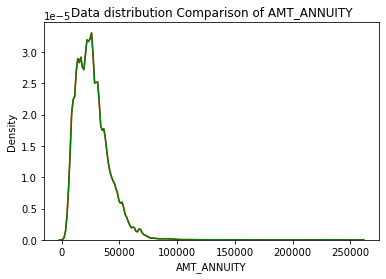

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


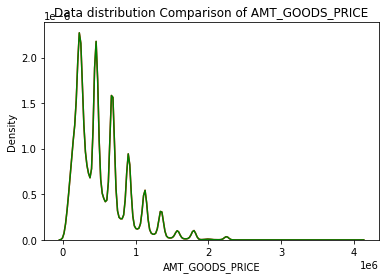

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


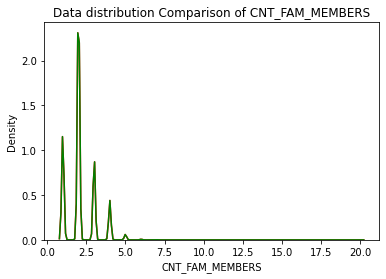

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


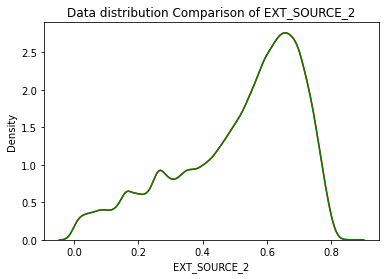

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


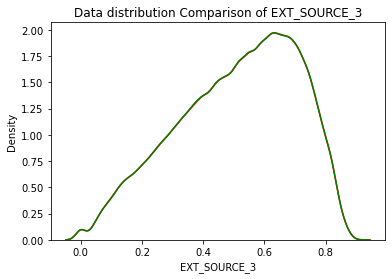

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


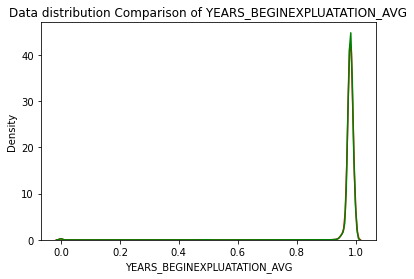

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


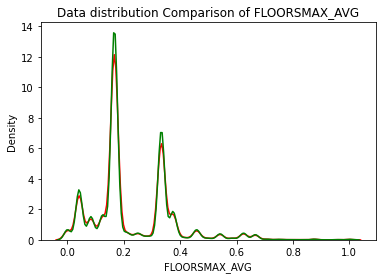

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


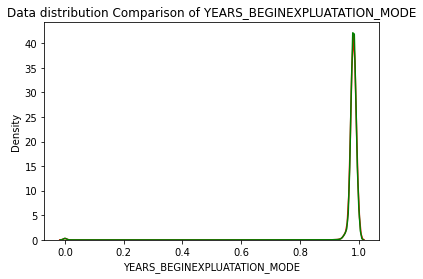

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


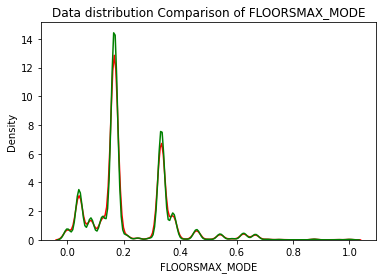

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


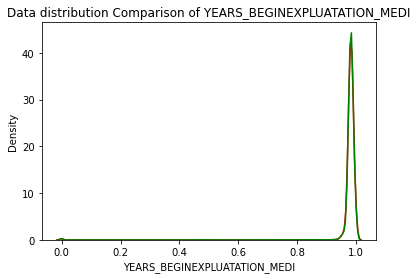

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


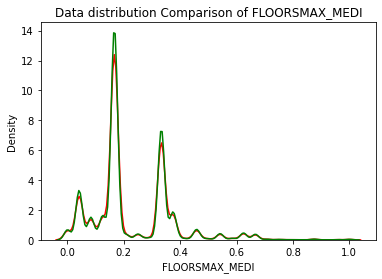

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


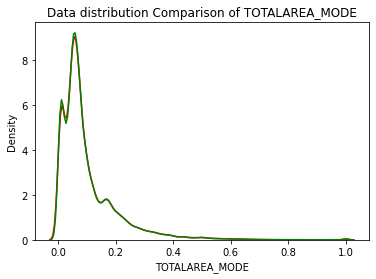

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


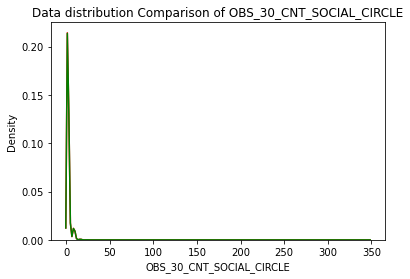

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


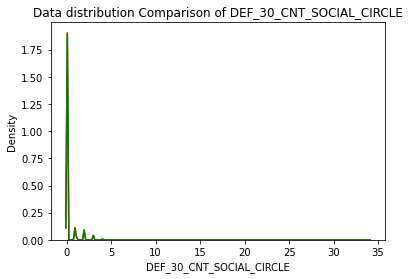

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


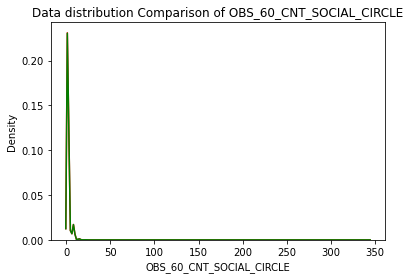

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


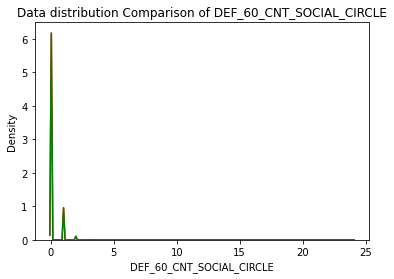

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


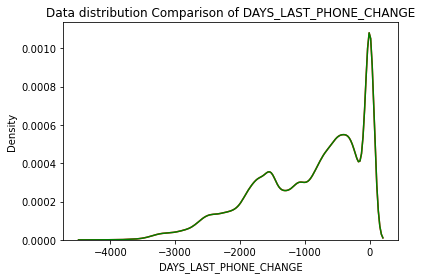

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


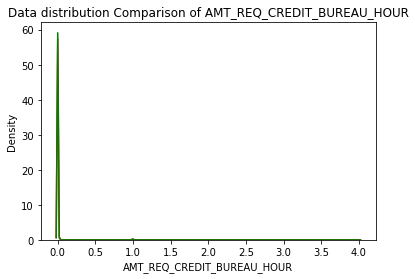

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


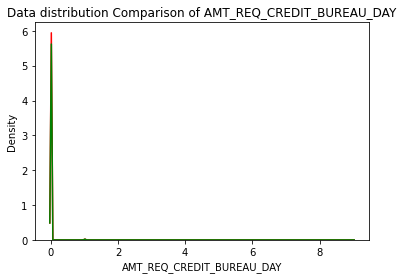

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


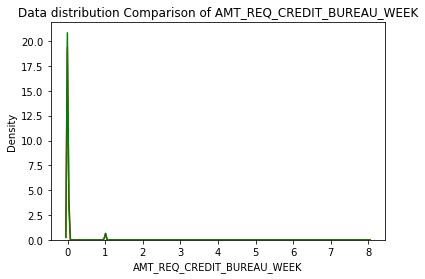

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


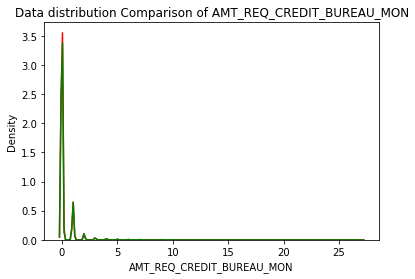

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


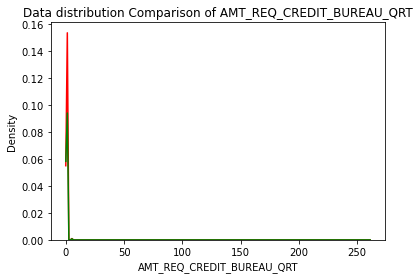

<ipython-input-22-435dd7a3c348>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df[col+'_impute'][loan_df[col].isnull()] = rand_val


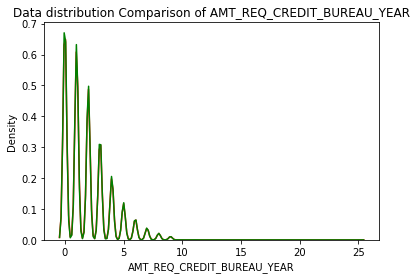

In [23]:
for col in less_50:
    imputeRandomVal(col)

We can clearly see on above plots that data variance is almost same after imputing random missing values. Now we can drop less_50 columns and keep imputed cols

In [24]:
loan_df.drop(less_50, axis=1, inplace=True)

In [25]:
loan_df[gr_eq_50].describe().T

,count,mean,std,min,25%,50%,75%,max
OWN_CAR_AGE,104582.0,12.061091,11.944812,0.000000,5.000000,9.000000,15.000000,91.000000
EXT_SOURCE_1,134133.0,0.502130,0.211062,0.014568,0.334007,0.505998,0.675053,0.962693
APARTMENTS_AVG,151450.0,0.117440,0.108240,0.000000,0.057700,0.087600,0.148500,1.000000
BASEMENTAREA_AVG,127568.0,0.088442,0.082438,0.000000,0.044200,0.076300,0.112200,1.000000
YEARS_BUILD_AVG,103023.0,0.752471,0.113280,0.000000,0.687200,0.755200,0.823200,1.000000
COMMONAREA_AVG,92646.0,0.044621,0.076036,0.000000,0.007800,0.021100,0.051500,1.000000
ELEVATORS_AVG,143620.0,0.078942,0.134576,0.000000,0.000000,0.000000,0.120000,1.000000
ENTRANCES_AVG,152683.0,0.149725,0.100049,0.000000,0.069000,0.137900,0.206900,1.000000
FLOORSMIN_AVG,98869.0,0.231894,0.161380,0.000000,0.083300,0.208300,0.375000,1.000000
LANDAREA_AVG,124921.0,0.066333,0.081184,0.000000,0.018700,0.048100,0.085600,1.000000


OWN_CAR_AGE feature has high mean its data is not normally distributed. There are chances that it contains the outliers

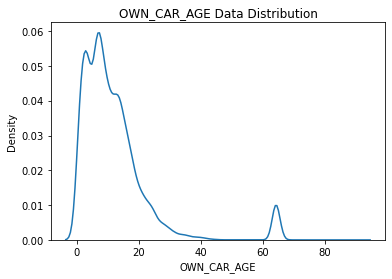

In [26]:
sns.kdeplot(x=loan_df['OWN_CAR_AGE'])
plt.title('OWN_CAR_AGE Data Distribution')
plt.show()

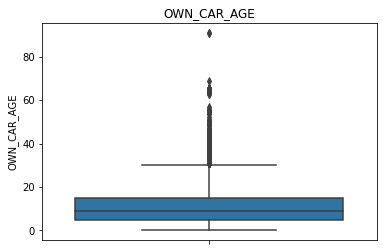

In [27]:
sns.boxplot(y=loan_df['OWN_CAR_AGE'])
plt.title('OWN_CAR_AGE')
plt.show()

As we suspected there are some outliers present so we can't do mean imputation in it for this we will do median imputation and for rest of the features we will go with mean imputation

In [28]:
for col in gr_eq_50:
    if(col != 'OWN_CAN_AGE'):
        loan_df[col].fillna(loan_df[col].mean(), inplace=True)
    else:
        loan_df[col].fillna(loan_df[col].medain(), inplace=True)
        
loan_df.isnull().sum().sum()

0

## ------------ Imputed all missing values ------------------

## Checking for numerical categorical feature in dataset

In [29]:
# updated numeric columns
num_cols = loan_df.drop('TARGET', axis=1).select_dtypes(exclude='object').columns

In [30]:
# Creating list of expected categorical columns from the numerical columns

expected_num_cat_cols = []
for col in num_cols:
    unique_val_count = loan_df[col].value_counts().count()
    print(f"{col} has {unique_val_count} unique values")
    if(unique_val_count <= 24):
        expected_num_cat_cols.append(col)
    print("==============================================================")

CNT_CHILDREN has 15 unique values
AMT_INCOME_TOTAL has 2548 unique values
AMT_CREDIT has 5603 unique values
REGION_POPULATION_RELATIVE has 81 unique values
DAYS_BIRTH has 17460 unique values
DAYS_EMPLOYED has 12574 unique values
DAYS_REGISTRATION has 15688 unique values
DAYS_ID_PUBLISH has 6168 unique values
OWN_CAR_AGE has 63 unique values
FLAG_MOBIL has 2 unique values
FLAG_EMP_PHONE has 2 unique values
FLAG_WORK_PHONE has 2 unique values
FLAG_CONT_MOBILE has 2 unique values
FLAG_PHONE has 2 unique values
FLAG_EMAIL has 2 unique values
REGION_RATING_CLIENT has 3 unique values
REGION_RATING_CLIENT_W_CITY has 3 unique values
HOUR_APPR_PROCESS_START has 24 unique values
REG_REGION_NOT_LIVE_REGION has 2 unique values
REG_REGION_NOT_WORK_REGION has 2 unique values
LIVE_REGION_NOT_WORK_REGION has 2 unique values
REG_CITY_NOT_LIVE_CITY has 2 unique values
REG_CITY_NOT_WORK_CITY has 2 unique values
LIVE_CITY_NOT_WORK_CITY has 2 unique values
EXT_SOURCE_1 has 114585 unique values
APARTMENTS_A

FLOORSMAX_MEDI_impute has 49 unique values
TOTALAREA_MODE_impute has 5116 unique values
OBS_30_CNT_SOCIAL_CIRCLE_impute has 33 unique values
DEF_30_CNT_SOCIAL_CIRCLE_impute has 10 unique values
OBS_60_CNT_SOCIAL_CIRCLE_impute has 33 unique values
DEF_60_CNT_SOCIAL_CIRCLE_impute has 9 unique values
DAYS_LAST_PHONE_CHANGE_impute has 3773 unique values
AMT_REQ_CREDIT_BUREAU_HOUR_impute has 5 unique values
AMT_REQ_CREDIT_BUREAU_DAY_impute has 9 unique values
AMT_REQ_CREDIT_BUREAU_WEEK_impute has 9 unique values
AMT_REQ_CREDIT_BUREAU_MON_impute has 24 unique values
AMT_REQ_CREDIT_BUREAU_QRT_impute has 11 unique values
AMT_REQ_CREDIT_BUREAU_YEAR_impute has 25 unique values


In [31]:
# checking all the unique values present in expected_num_cat_cols
for col in expected_num_cat_cols:
    print(f"{col} has {loan_df[col].value_counts()} unique values")
    print("==============================================================")

CNT_CHILDREN has 0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
10         2
12         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64 unique values
FLAG_MOBIL has 1    307510
0         1
Name: FLAG_MOBIL, dtype: int64 unique values
FLAG_EMP_PHONE has 1    252125
0     55386
Name: FLAG_EMP_PHONE, dtype: int64 unique values
FLAG_WORK_PHONE has 0    246203
1     61308
Name: FLAG_WORK_PHONE, dtype: int64 unique values
FLAG_CONT_MOBILE has 1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64 unique values
FLAG_PHONE has 0    221080
1     86431
Name: FLAG_PHONE, dtype: int64 unique values
FLAG_EMAIL has 0    290069
1     17442
Name: FLAG_EMAIL, dtype: int64 unique values
REGION_RATING_CLIENT has 2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64 unique values
REGION_RATING_CLIENT_W_CITY has 2    229484
3     43860
1     34167
Name: REGION_RATING_CLI

**All above features are ranging b/w 0-24 except AMT_REQ_CREDIT_BUREAU_QRT_impute,DEF_30_CNT_SOCIAL_CIRCLE_impute both have 1 value > 24 which can be outlier**

In [32]:
# Checking if we can find other ranged cat cols
unique_val_ls_50=[]
for col in num_cols:
    unique_val_count = loan_df[col].value_counts().count()
    if(unique_val_count <= 50):
        unique_val_ls_50.append(col)
    print(f"{col} has {unique_val_count} unique values")
    print("==============================================================")

CNT_CHILDREN has 15 unique values
AMT_INCOME_TOTAL has 2548 unique values
AMT_CREDIT has 5603 unique values
REGION_POPULATION_RELATIVE has 81 unique values
DAYS_BIRTH has 17460 unique values
DAYS_EMPLOYED has 12574 unique values
DAYS_REGISTRATION has 15688 unique values
DAYS_ID_PUBLISH has 6168 unique values
OWN_CAR_AGE has 63 unique values
FLAG_MOBIL has 2 unique values
FLAG_EMP_PHONE has 2 unique values
FLAG_WORK_PHONE has 2 unique values
FLAG_CONT_MOBILE has 2 unique values
FLAG_PHONE has 2 unique values
FLAG_EMAIL has 2 unique values
REGION_RATING_CLIENT has 3 unique values
REGION_RATING_CLIENT_W_CITY has 3 unique values
HOUR_APPR_PROCESS_START has 24 unique values
REG_REGION_NOT_LIVE_REGION has 2 unique values
REG_REGION_NOT_WORK_REGION has 2 unique values
LIVE_REGION_NOT_WORK_REGION has 2 unique values
REG_CITY_NOT_LIVE_CITY has 2 unique values
REG_CITY_NOT_WORK_CITY has 2 unique values
LIVE_CITY_NOT_WORK_CITY has 2 unique values
EXT_SOURCE_1 has 114585 unique values
APARTMENTS_A

AMT_GOODS_PRICE_impute has 1002 unique values
CNT_FAM_MEMBERS_impute has 17 unique values
EXT_SOURCE_2_impute has 119831 unique values
EXT_SOURCE_3_impute has 814 unique values
YEARS_BEGINEXPLUATATION_AVG_impute has 285 unique values
FLOORSMAX_AVG_impute has 403 unique values
YEARS_BEGINEXPLUATATION_MODE_impute has 221 unique values
FLOORSMAX_MODE_impute has 25 unique values
YEARS_BEGINEXPLUATATION_MEDI_impute has 245 unique values
FLOORSMAX_MEDI_impute has 49 unique values
TOTALAREA_MODE_impute has 5116 unique values
OBS_30_CNT_SOCIAL_CIRCLE_impute has 33 unique values
DEF_30_CNT_SOCIAL_CIRCLE_impute has 10 unique values
OBS_60_CNT_SOCIAL_CIRCLE_impute has 33 unique values
DEF_60_CNT_SOCIAL_CIRCLE_impute has 9 unique values
DAYS_LAST_PHONE_CHANGE_impute has 3773 unique values
AMT_REQ_CREDIT_BUREAU_HOUR_impute has 5 unique values
AMT_REQ_CREDIT_BUREAU_DAY_impute has 9 unique values
AMT_REQ_CREDIT_BUREAU_WEEK_impute has 9 unique values
AMT_REQ_CREDIT_BUREAU_MON_impute has 24 unique valu

In [33]:
# checking all the unique values present in unique_val_ls_50
for col in unique_val_ls_50:
    print(f"{col} has {loan_df[col].value_counts()} unique values")
    print("==============================================================")

CNT_CHILDREN has 0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
10         2
12         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64 unique values
FLAG_MOBIL has 1    307510
0         1
Name: FLAG_MOBIL, dtype: int64 unique values
FLAG_EMP_PHONE has 1    252125
0     55386
Name: FLAG_EMP_PHONE, dtype: int64 unique values
FLAG_WORK_PHONE has 0    246203
1     61308
Name: FLAG_WORK_PHONE, dtype: int64 unique values
FLAG_CONT_MOBILE has 1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64 unique values
FLAG_PHONE has 0    221080
1     86431
Name: FLAG_PHONE, dtype: int64 unique values
FLAG_EMAIL has 0    290069
1     17442
Name: FLAG_EMAIL, dtype: int64 unique values
REGION_RATING_CLIENT has 2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64 unique values
REGION_RATING_CLIENT_W_CITY has 2    229484
3     43860
1     34167
Name: REGION_RATING_CLI

FLAG_DOCUMENT_20 has 0    307355
1       156
Name: FLAG_DOCUMENT_20, dtype: int64 unique values
FLAG_DOCUMENT_21 has 0    307408
1       103
Name: FLAG_DOCUMENT_21, dtype: int64 unique values
CNT_FAM_MEMBERS_impute has 2.0     158359
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
16.0         2
14.0         2
20.0         2
12.0         2
15.0         1
11.0         1
13.0         1
Name: CNT_FAM_MEMBERS_impute, dtype: int64 unique values
FLOORSMAX_MODE_impute has 0.1667    130462
0.3333     68416
0.0417     31098
0.3750     16569
0.1250     14464
0.0833     13513
0.0000      6793
0.4583      6397
0.6250      4131
0.5417      3654
0.6667      3409
0.2083      2988
0.2500      1136
0.2917      1018
0.5833       778
0.4167       470
0.8750       457
0.7083       396
0.5000       368
1.0000       327
0.7500       247
0.9583       188
0.7917       114
0.9167        75
0.8333        43
Name: FLOORSMAX_MO

**OBS_30_CNT_SOCIAL_CIRCLE_impute, OBS_60_CNT_SOCIAL_CIRCLE_impute, AMT_REQ_CREDIT_BUREAU_YEAR_impute are ranging b/w 0-50 with 1 outliers so marking as categorical**

In [34]:
expected_num_cat_cols.extend(['OBS_30_CNT_SOCIAL_CIRCLE_impute','OBS_60_CNT_SOCIAL_CIRCLE_impute','AMT_REQ_CREDIT_BUREAU_YEAR_impute'])

## Checking for outliers in numeric categorical features

In [35]:
for col in expected_num_cat_cols:
    print(f"{col} has {loan_df[col].value_counts()} unique values")
    print("==============================================================")

CNT_CHILDREN has 0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
10         2
12         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64 unique values
FLAG_MOBIL has 1    307510
0         1
Name: FLAG_MOBIL, dtype: int64 unique values
FLAG_EMP_PHONE has 1    252125
0     55386
Name: FLAG_EMP_PHONE, dtype: int64 unique values
FLAG_WORK_PHONE has 0    246203
1     61308
Name: FLAG_WORK_PHONE, dtype: int64 unique values
FLAG_CONT_MOBILE has 1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64 unique values
FLAG_PHONE has 0    221080
1     86431
Name: FLAG_PHONE, dtype: int64 unique values
FLAG_EMAIL has 0    290069
1     17442
Name: FLAG_EMAIL, dtype: int64 unique values
REGION_RATING_CLIENT has 2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64 unique values
REGION_RATING_CLIENT_W_CITY has 2    229484
3     43860
1     34167
Name: REGION_RATING_CLI

OBS_30_CNT_SOCIAL_CIRCLE_impute has 0.0      164431
1.0       48959
2.0       29925
3.0       20388
4.0       14195
5.0        9581
6.0        6481
7.0        4402
8.0        2970
9.0        2015
10.0       1376
11.0        856
12.0        653
13.0        412
14.0        258
15.0        166
16.0        133
17.0         88
18.0         46
19.0         44
20.0         30
21.0         29
22.0         22
23.0         15
24.0         11
25.0         11
27.0          5
26.0          3
30.0          2
348.0         1
28.0          1
47.0          1
29.0          1
Name: OBS_30_CNT_SOCIAL_CIRCLE_impute, dtype: int64 unique values
OBS_60_CNT_SOCIAL_CIRCLE_impute has 0.0      165231
1.0       49033
2.0       29851
3.0       20278
4.0       13988
5.0        9494
6.0        6377
7.0        4363
8.0        2895
9.0        1963
10.0       1341
11.0        839
12.0        621
13.0        401
14.0        238
15.0        167
16.0        138
17.0         73
18.0         50
19.0         44
20.0         3

In [36]:
# AMT_REQ_CREDIT_BUREAU_QRT_impute has 1 outlier replacing it > 7 with 8
loan_df['AMT_REQ_CREDIT_BUREAU_QRT_impute'] = np.where(loan_df['AMT_REQ_CREDIT_BUREAU_QRT_impute']>7, 8, loan_df['AMT_REQ_CREDIT_BUREAU_QRT_impute'] )

In [37]:
# OBS_30_CNT_SOCIAL_CIRCLE_impute replacing > 25 values with 26
loan_df['OBS_30_CNT_SOCIAL_CIRCLE_impute'] = np.where(loan_df['OBS_30_CNT_SOCIAL_CIRCLE_impute']>25, 26, loan_df['OBS_30_CNT_SOCIAL_CIRCLE_impute'] )

In [38]:
# OBS_60_CNT_SOCIAL_CIRCLE_impute replacing > 30 values with 31
loan_df['OBS_60_CNT_SOCIAL_CIRCLE_impute'] = np.where(loan_df['OBS_60_CNT_SOCIAL_CIRCLE_impute']>30, 31, loan_df['OBS_60_CNT_SOCIAL_CIRCLE_impute'] )

In [39]:
# Updating num_cols by removing expected_num_cat_cols from it
num_cols = num_cols.drop(expected_num_cat_cols)

### Converting numerial days or years range cols into categorical cols

In [40]:
# Analyzing rest num cols to check if we can convert into bins 
for col in num_cols:
    print(f"{col} has {loan_df[col].value_counts()} unique values")
    print("==============================================================")

AMT_INCOME_TOTAL has 135000.0    35750
112500.0    31019
157500.0    26556
180000.0    24719
90000.0     22483
            ...  
83479.5         1
44955.0         1
78916.5         1
37008.0         1
131125.5        1
Name: AMT_INCOME_TOTAL, Length: 2548, dtype: int64 unique values
AMT_CREDIT has 450000.0     9709
675000.0     8877
225000.0     8162
180000.0     7342
270000.0     7241
             ... 
859581.0        1
2129634.0       1
1860813.0       1
1013836.5       1
1500642.0       1
Name: AMT_CREDIT, Length: 5603, dtype: int64 unique values
REGION_POPULATION_RELATIVE has 0.035792    16408
0.046220    13442
0.030755    12163
0.025164    11950
0.026392    11601
            ...  
0.001417      467
0.001333      235
0.000533       39
0.000938       28
0.000290        2
Name: REGION_POPULATION_RELATIVE, Length: 81, dtype: int64 unique values
DAYS_BIRTH has -13749    43
-13481    42
-10020    41
-18248    41
-15771    40
          ..
-24988     1
-7829      1
-25179     1
-25070    

LIVINGAREA_MODE has 0.105975    154350
0.000000       444
0.053000       272
0.053200       262
0.052900       249
             ...  
0.423200         1
0.764600         1
0.379900         1
0.554200         1
0.345000         1
Name: LIVINGAREA_MODE, Length: 5302, dtype: int64 unique values
NONLIVINGAPARTMENTS_MODE has 0.008076    213514
0.000000     59255
0.003900     14105
0.007800      6413
0.011700      3675
             ...  
0.486400         1
0.887200         1
0.431900         1
0.735400         1
0.828800         1
Name: NONLIVINGAPARTMENTS_MODE, Length: 168, dtype: int64 unique values
NONLIVINGAREA_MODE has 0.027022    169682
0.000000     67126
0.001100       477
0.004600       466
0.003300       430
             ...  
0.444500         1
0.422700         1
0.177000         1
0.446600         1
0.237900         1
Name: NONLIVINGAREA_MODE, Length: 3328, dtype: int64 unique values
APARTMENTS_MEDI has 0.11785    156061
0.08330      7109
0.06250      6687
0.09370      4622
0.0729

EXT_SOURCE_3_impute has 0.746300    1845
0.713631    1624
0.694093    1586
0.670652    1496
0.652897    1448
            ... 
0.026921       1
0.017506       1
0.020455       1
0.020026       1
0.013948       1
Name: EXT_SOURCE_3_impute, Length: 814, dtype: int64 unique values
YEARS_BEGINEXPLUATATION_AVG_impute has 0.9871    8404
0.9856    8193
0.9861    8160
0.9801    8052
0.9866    8029
          ... 
0.9076       2
0.3229       2
0.4938       2
0.8400       2
0.4908       1
Name: YEARS_BEGINEXPLUATATION_AVG_impute, Length: 285, dtype: int64 unique values
FLOORSMAX_AVG_impute has 0.1667    123133
0.3333     63503
0.0417     29081
0.3750     15766
0.1250     13889
           ...  
0.1133         2
0.3154         2
0.4758         2
0.1200         2
0.2462         2
Name: FLOORSMAX_AVG_impute, Length: 403, dtype: int64 unique values
YEARS_BEGINEXPLUATATION_MODE_impute has 0.9871    8372
0.9861    8154
0.9866    8145
0.9801    8021
0.9806    7986
          ... 
0.9166       2
0.8853     

**Max Ranges is decided based on 0.10(-ve values) and 0.90(+ve values) quantile also checked min max values to set min, max ranges**

1. DAYS_BIRTH -- Can be categorized as <= 18 years = 1, <= 25 years = 2, <= 35 years = 3, <= 45 years = 4, <= 60 years = 5 and > 60 years = 6
2. DAYS_EMPLOYED -- Can be categorized as <= 1 year = 1, <= 3 year = 2, <= 5 year = 3, <= 8 year = 4, <= 10 year = 5, <= 15 year = 6, > 15 year = 7
3. DAYS_REGISTRATION -- Can be categorized as <= 7 days = 1, <= 1 month = 2, <= 6 month = 3, <= 1 year = 4, <= 5 year = 5, <= 10 year = 6,<= 15 year = 7,<= 20 year = 8,<= 25 year = 9,<= 30 year = 10, > 30 year = 11
4. DAYS_ID_PUBLISH -- can be categorized as <= 7 days = 1, <= 1 month = 2, <= 6 month = 3, <= 1 year = 4, <= 5 year = 5, <= 10 year = 6, <= 15 year = 7, > 15 year = 8
5. OWN_CAR_AGE -- can be categorized as <= 1 year = 1, <= 5 years = 2, <= 10 years = 3, <= 15 years = 4, <= 20 years = 5, > 20 year = 6
6. DAYS_LAST_PHONE_CHANGE_impute -- can be categorized as <= 7 days = 1, <= 1 month = 2, <= 6 month = 3, <= 1 year = 4, <= 2 year = 5, <= 3 year = 6, <= 4 year = 7, <= 5 year = 8, > 5 year = 9

In [41]:
def numDataToRange(col, ranges):
    loan_df[col+'_cat'] = np.where(abs(loan_df[col]) <= ranges[0], 1, loan_df[col])
    for i,range in enumerate(ranges):
        if(i == 0):
            continue
        elif(i < (len(ranges)-1)):
            loan_df[col+'_cat'] = np.where(((abs(loan_df[col+'_cat']) > ranges[i-1]) & (abs(loan_df[col+'_cat']) <= ranges[i])), (i+1), loan_df[col+'_cat'])
        else:
            loan_df[col+'_cat'] = np.where(abs(loan_df[col+'_cat']) > ranges[i], (i+1), loan_df[col+'_cat'])

In [42]:
# Replace DAYS_BIRTH based on above decided range. Ranges are in years and data in days so need to convert accordingly
numDataToRange('DAYS_BIRTH', np.array([18,25,35,45,60,60])*365)
loan_df['DAYS_BIRTH_cat'].value_counts()

5    103197
4     84274
3     72302
6     35579
2     12159
Name: DAYS_BIRTH_cat, dtype: int64

In [43]:
# Replace DAYS_EMPLOYED based on above decided range. Ranges are in years and data in days so need to convert accordingly
numDataToRange('DAYS_EMPLOYED', np.array([1,3,5,8,10,15,15])*365)
loan_df['DAYS_EMPLOYED_cat'].value_counts()

7    78779
2    61472
3    46857
4    44461
1    27982
6    27549
5    20411
Name: DAYS_EMPLOYED_cat, dtype: int64

In [44]:
# Replace DAYS_REGISTRATION based on above decided range. Ranges are in years and data in days so need to convert accordingly
ranges = [7,30,6*30]
ranges.extend(list(np.array([1,5,10,15,20,25,30,30])*365))
numDataToRange('DAYS_REGISTRATION', ranges)
loan_df['DAYS_REGISTRATION_cat'].value_counts()

7.0     58692
5.0     54704
6.0     54614
8.0     41965
9.0     36495
10.0    25096
11.0    19048
4.0      7993
3.0      6782
2.0      1381
1.0       741
Name: DAYS_REGISTRATION_cat, dtype: int64

In [45]:
# Replace DAYS_ID_PUBLISH based on above decided range. Ranges are in years and data in days so need to convert accordingly
ranges = [7,30,6*30]
ranges.extend(list(np.array([1,5,10,15,15])*365))
numDataToRange('DAYS_ID_PUBLISH', ranges)
loan_df['DAYS_ID_PUBLISH_cat'].value_counts()

7    130120
6     92698
5     66874
4      7157
3      5984
8      2876
2      1327
1       475
Name: DAYS_ID_PUBLISH_cat, dtype: int64

In [46]:
# Replace OWN_CAR_AGE based on above decided range.
numDataToRange('OWN_CAR_AGE', [1,5,10,15,20,20])
loan_df['OWN_CAR_AGE_cat'].value_counts()

4.0    224087
3.0     29519
2.0     21374
6.0     13054
5.0     12063
1.0      7414
Name: OWN_CAR_AGE_cat, dtype: int64

In [47]:
# Replace DAYS_LAST_PHONE_CHANGE_impute based on above decided range. Ranges are in years and data in days so need to convert accordingly
ranges = [7,30,6*30]
ranges.extend(list(np.array([1,2,3,4,5,5])*365))
numDataToRange('DAYS_LAST_PHONE_CHANGE_impute', ranges)
loan_df['DAYS_LAST_PHONE_CHANGE_impute_cat'].value_counts()

5.0    57621
9.0    51394
1.0    47654
8.0    38070
6.0    37876
7.0    29929
4.0    28710
3.0    12912
2.0     3345
Name: DAYS_LAST_PHONE_CHANGE_impute_cat, dtype: int64

### Adding these new cols in expected_num_cat_cols and droping from num_cols and loan_df

In [48]:
expected_num_cat_cols.extend(['DAYS_BIRTH_cat','DAYS_EMPLOYED_cat','DAYS_REGISTRATION_cat','DAYS_ID_PUBLISH_cat','OWN_CAR_AGE_cat','DAYS_LAST_PHONE_CHANGE_impute_cat'])
num_cols = num_cols.drop(['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE','DAYS_LAST_PHONE_CHANGE_impute'])

In [49]:
loan_df.drop(['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE','DAYS_LAST_PHONE_CHANGE_impute'],axis=1, inplace=True)

In [50]:
loan_df.shape

(307511, 121)

### Checking for Outliers for num_cols

In [51]:
loan_df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
EXT_SOURCE_1,307511.0,0.502130,0.139395,1.456813e-02,0.502130,0.502130,0.502130,9.626928e-01
APARTMENTS_AVG,307511.0,0.117440,0.075961,0.000000e+00,0.089700,0.117440,0.117440,1.000000e+00
BASEMENTAREA_AVG,307511.0,0.088442,0.053097,0.000000e+00,0.086300,0.088442,0.088442,1.000000e+00
YEARS_BUILD_AVG,307511.0,0.752471,0.065567,0.000000e+00,0.752471,0.752471,0.752471,1.000000e+00
COMMONAREA_AVG,307511.0,0.044621,0.041735,0.000000e+00,0.044621,0.044621,0.044621,1.000000e+00
ELEVATORS_AVG,307511.0,0.078942,0.091970,0.000000e+00,0.000000,0.078942,0.078942,1.000000e+00
ENTRANCES_AVG,307511.0,0.149725,0.070498,0.000000e+00,0.137900,0.149725,0.149725,1.000000e+00


In [52]:
high_mean_col = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY_impute','AMT_GOODS_PRICE_impute']

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


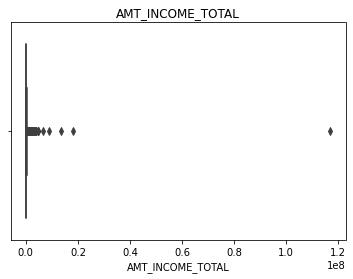

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


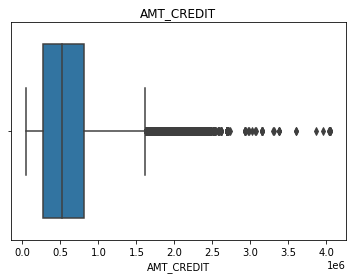

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


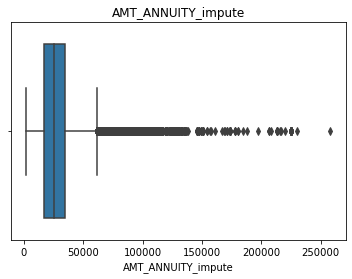

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


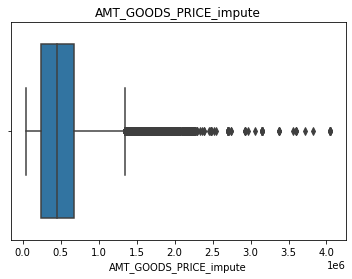

In [53]:
for col in high_mean_col:
    sns.boxplot(loan_df[col])
    plt.title(col)
    plt.show()

**All values are right skewd**

In [54]:

def outlierDetails(col, limits):
    try:
        if((type(limits) == float) or (type(limits) == int)):
            lower_quantile = limits
            upper_quantile = 1 - limits
        else:
            lower_quantile = limits[0]
            upper_quantile = limits[1]
    
        iqr = loan_df[col].quantile(upper_quantile)-loan_df[col].quantile(lower_quantile)
        lower_bond = loan_df[col].quantile(lower_quantile)-(1.5*iqr)
        upper_bond = loan_df[col].quantile(upper_quantile)+(1.5*iqr)
        outlier_percentage = loan_df[col].loc[((loan_df[col] < lower_bond) | (loan_df[col] > upper_bond))].shape[0] / loan_df.shape[0]
        
        return (lower_bond, upper_bond, outlier_percentage)
    except Exception as e:
        print("Error:-",e)

In [55]:
# Creating function for log transformatio
def logTransform(col, new_col):
    loan_df[new_col] = np.log(loan_df[col])

In [56]:
# Creating function for winsorizing the outliers
from scipy.stats.mstats import winsorize
def winsorizing(col, new_col, limits):
    loan_df[new_col] = winsorize(loan_df[col], limits=limits)

**Performing log transformation it will handle outliers by transforming values in low range. Applying winsorizing with 0.25 and 0.75 limit which will replace outlier values with 0.25 or 0.75 quantile value**

In [57]:
limits = [0.25,0.75]
for col in high_mean_col:
    logTransform(col,col+'_log')
    outlier_details = outlierDetails(col+'_log',limits)
    print(f"{col} Outlier Details After Log Transformation {outlier_details}")
    print("-----------------------------------------------------------------")
    if(outlier_details[2] > 0):
        winsorizing(col,col+'_win',limits)
        outlier_details = outlierDetails(col+'_win',limits)
        print(f"{col} Outlier Details After Winsorizing {outlier_details}")
        print("===========================================================")
        loan_df.drop(col+'_log',axis=1,inplace=True)
    loan_df.drop(col, axis=1,inplace=True)

AMT_INCOME_TOTAL Outlier Details After Log Transformation (10.749028503273435, 13.100175162881909, 0.02143337961894046)
-----------------------------------------------------------------
AMT_INCOME_TOTAL Outlier Details After Winsorizing (112500.0, 112500.0, 0.0)
AMT_CREDIT Outlier Details After Log Transformation (10.860760890629392, 15.248537816899043, 0.003102328046801578)
-----------------------------------------------------------------
AMT_CREDIT Outlier Details After Winsorizing (270000.0, 270000.0, 0.0)
AMT_ANNUITY_impute Outlier Details After Log Transformation (8.604182850152032, 11.559879645791025, 0.007297299933986101)
-----------------------------------------------------------------
AMT_ANNUITY_impute Outlier Details After Winsorizing (16524.0, 16524.0, 0.0)
AMT_GOODS_PRICE_impute Outlier Details After Log Transformation (10.811642704416332, 14.999594397467536, 0.004373827277723398)
-----------------------------------------------------------------
AMT_GOODS_PRICE_impute Outl

In [58]:
loan_df.shape

(307511, 121)

In [59]:
low_mean_col = num_cols.drop(high_mean_col)
num_cols = num_cols.drop(high_mean_col)

## Data Visualization

### 1. Categorical values effect on target

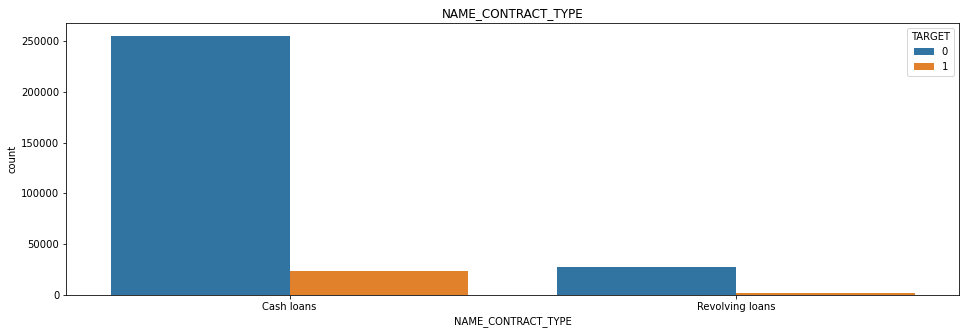

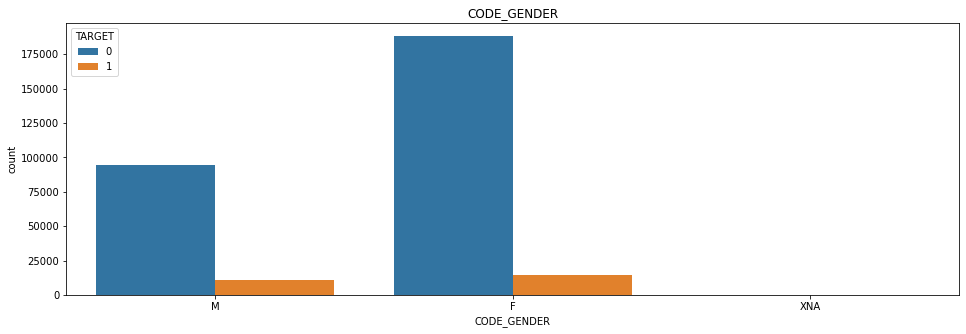

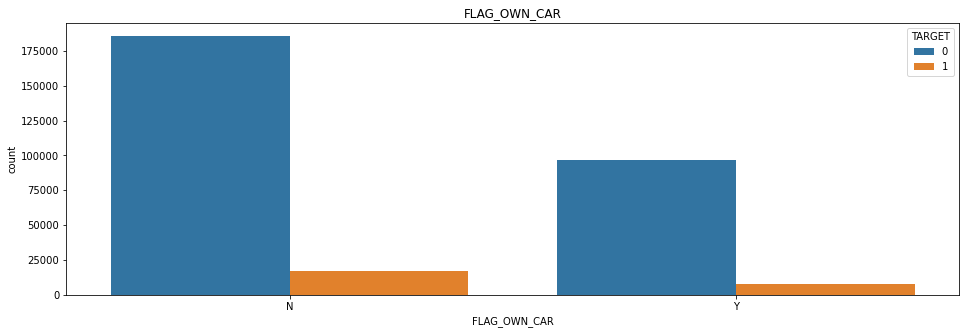

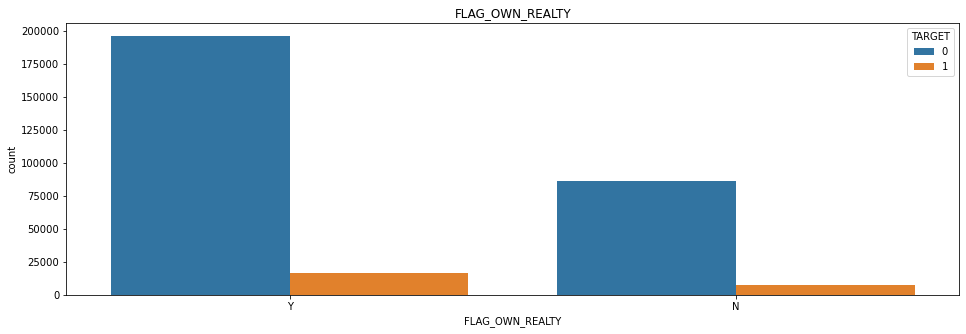

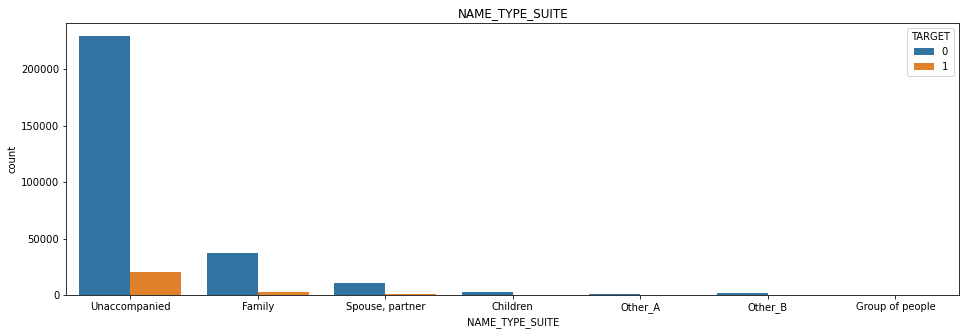

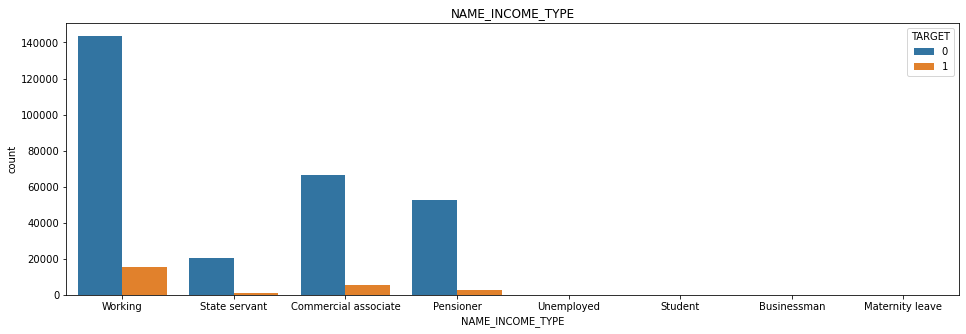

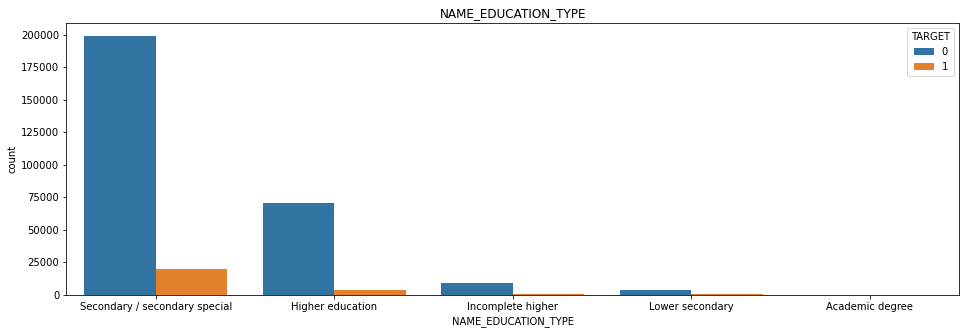

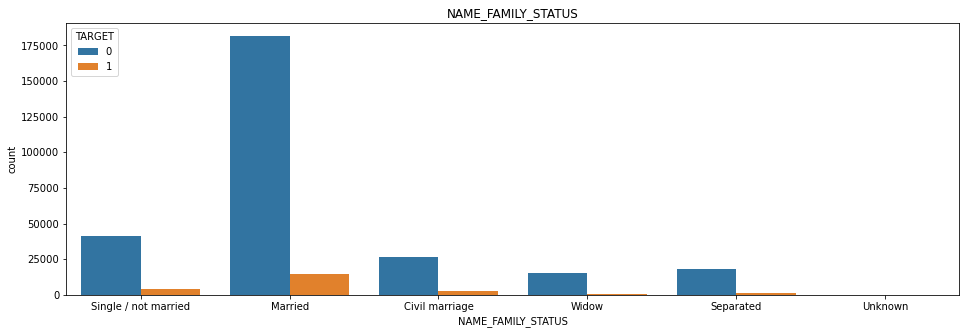

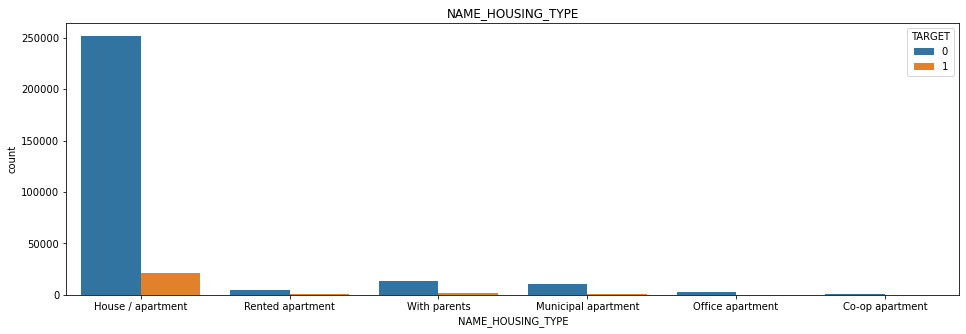

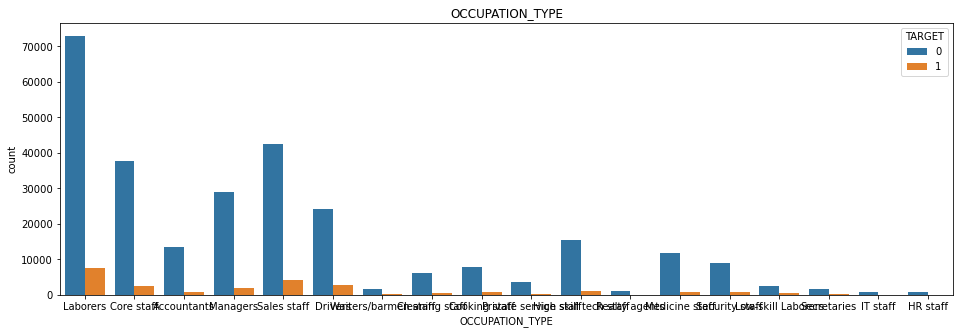

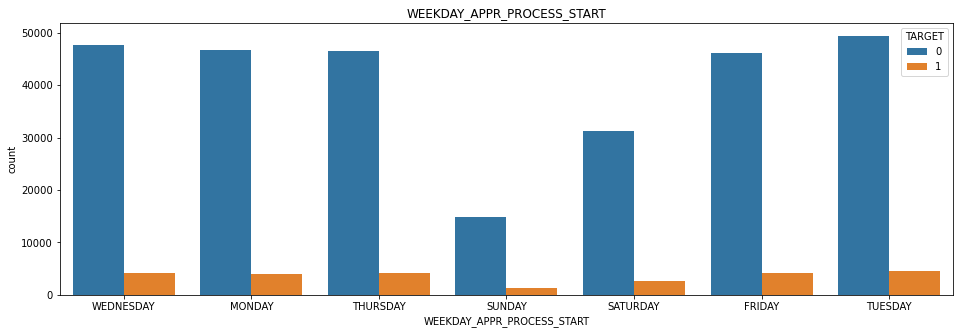

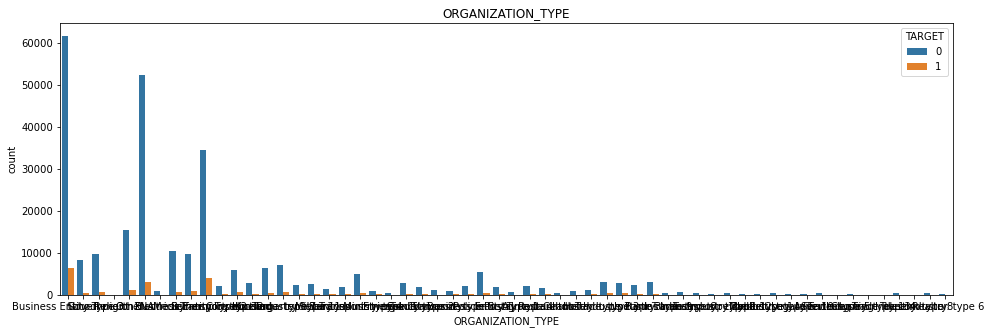

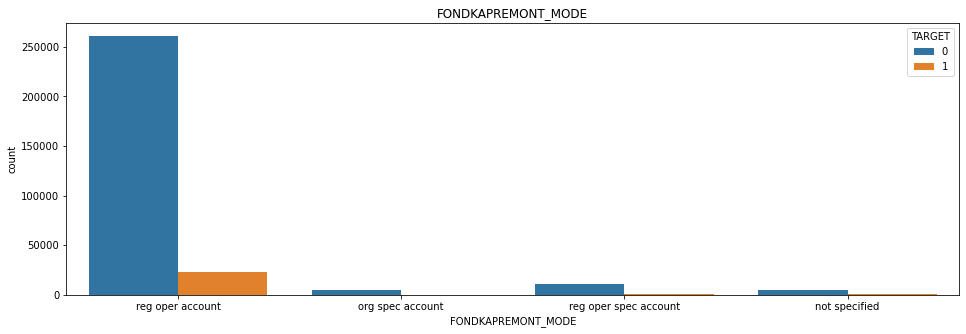

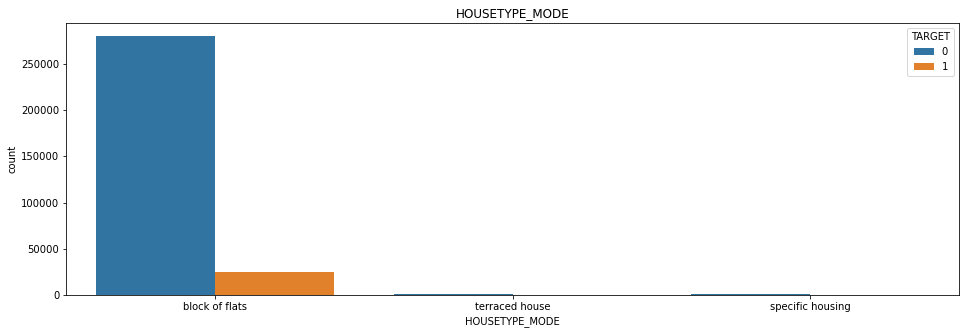

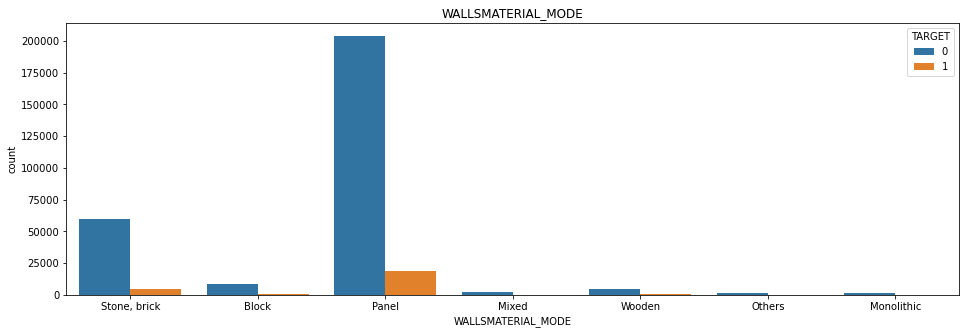

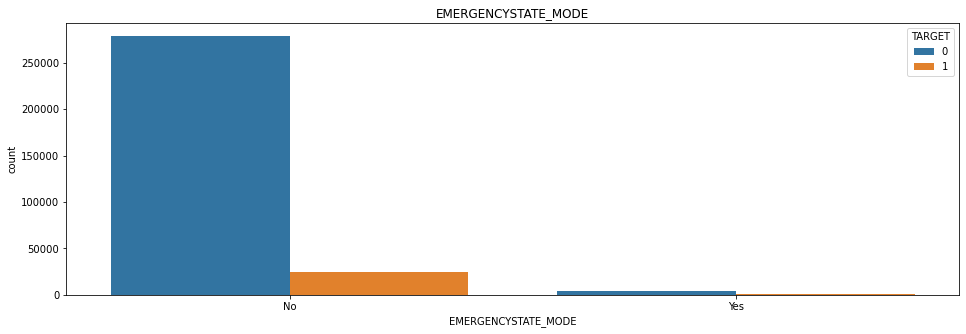

In [60]:
for col in cat_col:
    plt.figure(figsize=(16,5))
    sns.countplot(x=loan_df[col], hue=loan_df['TARGET'])
    plt.title(col)
    plt.show()

**We can make any assumption by looking above charts because in every chart defaulters are incresing if loans on that category is increasing**

### 2. Numeric categorical effects on target

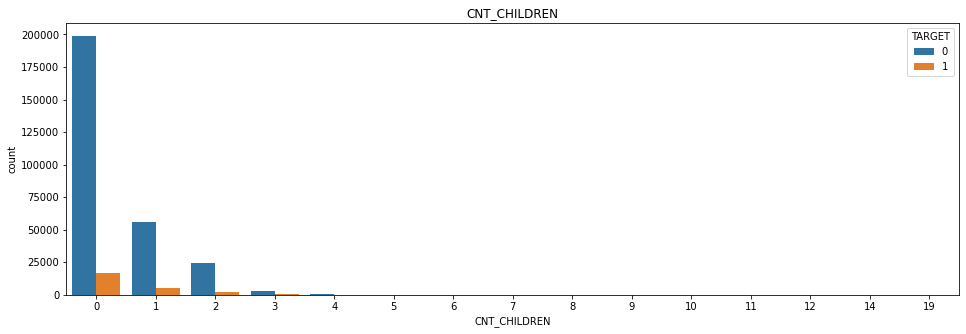

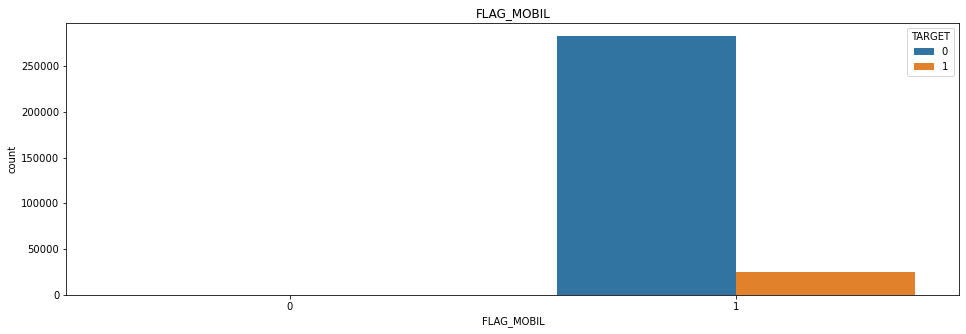

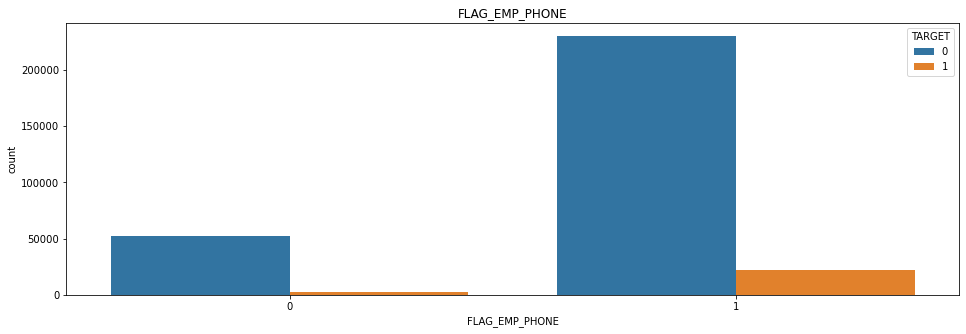

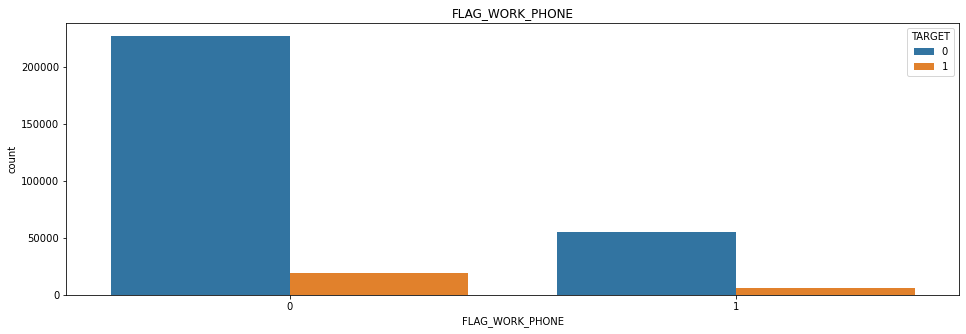

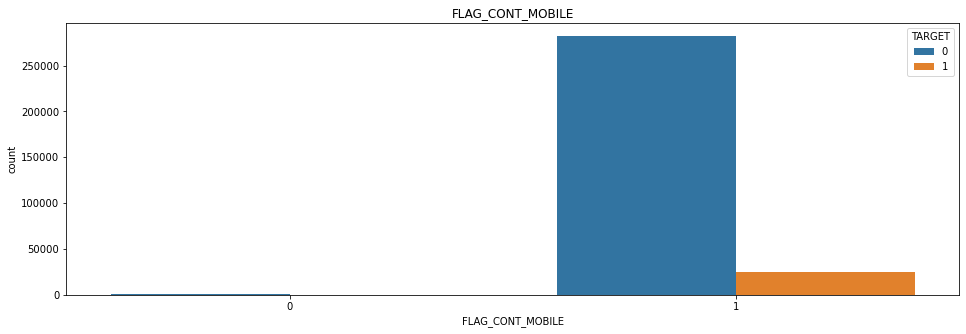

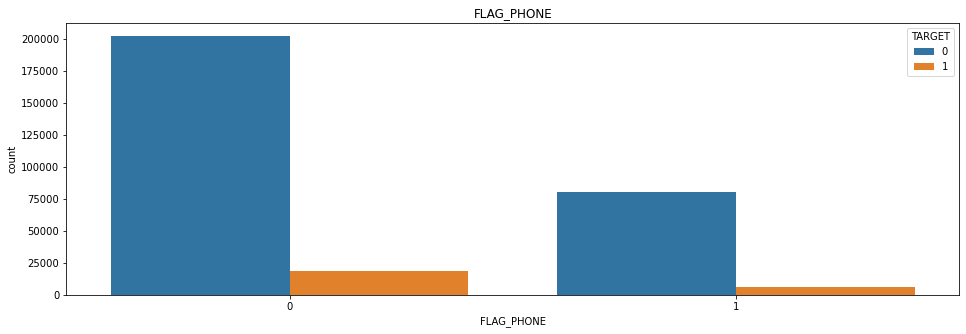

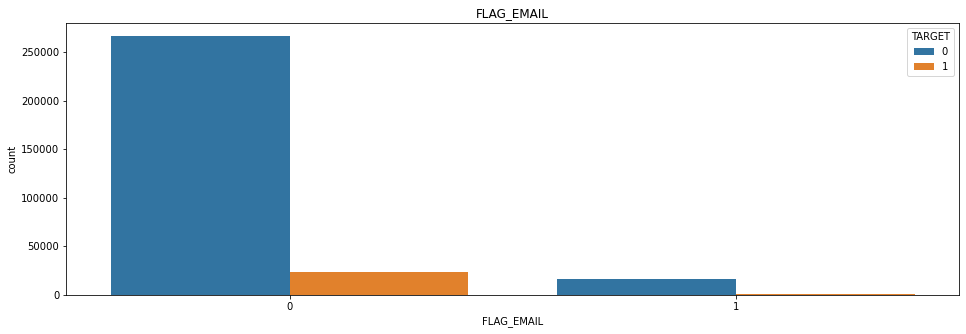

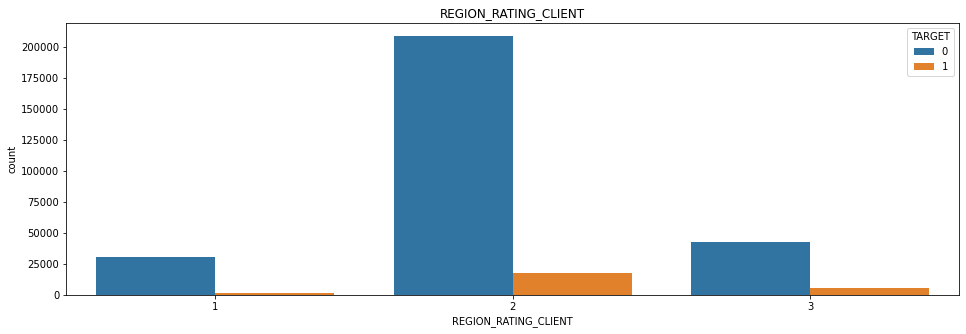

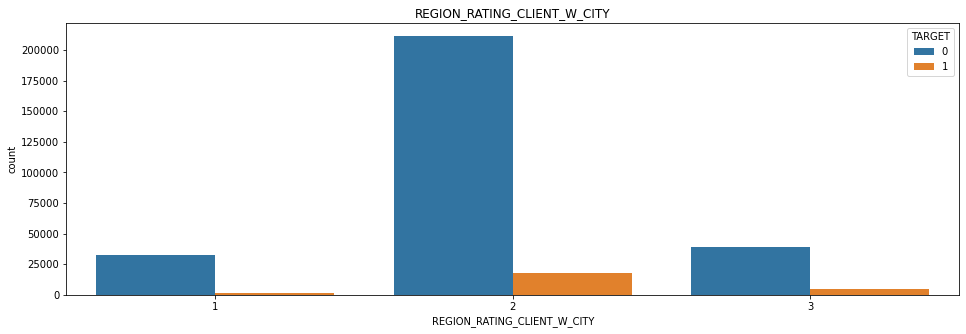

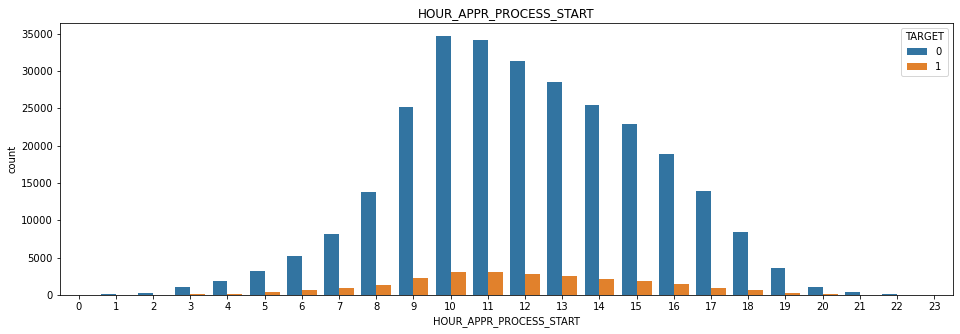

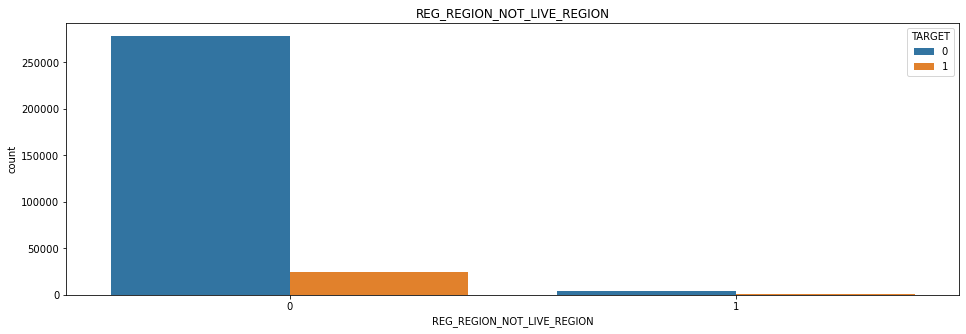

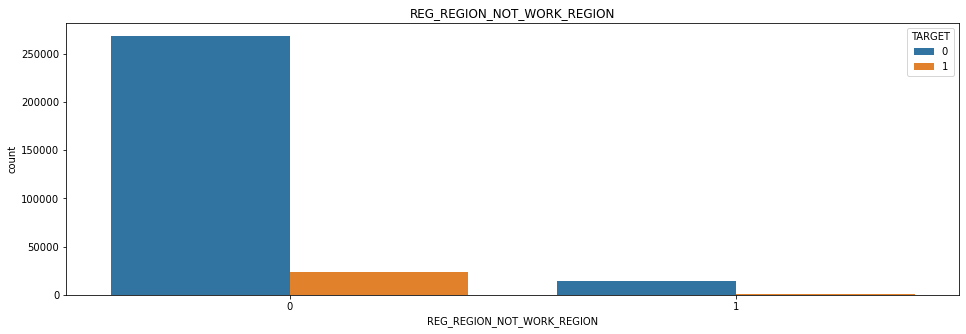

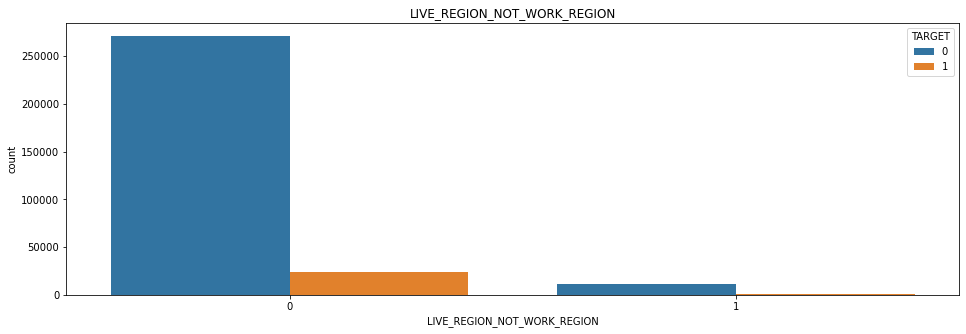

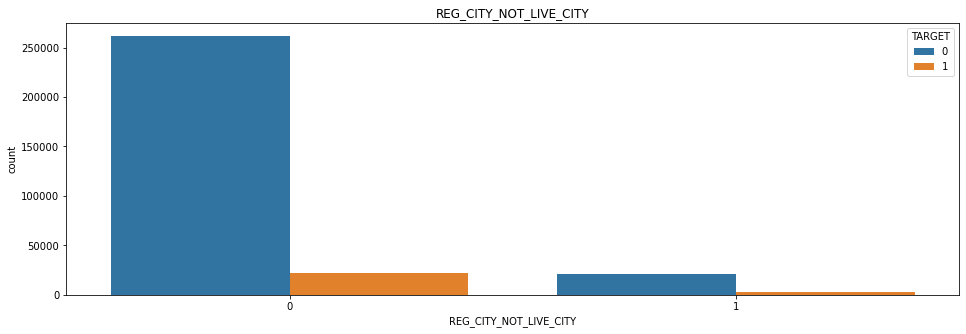

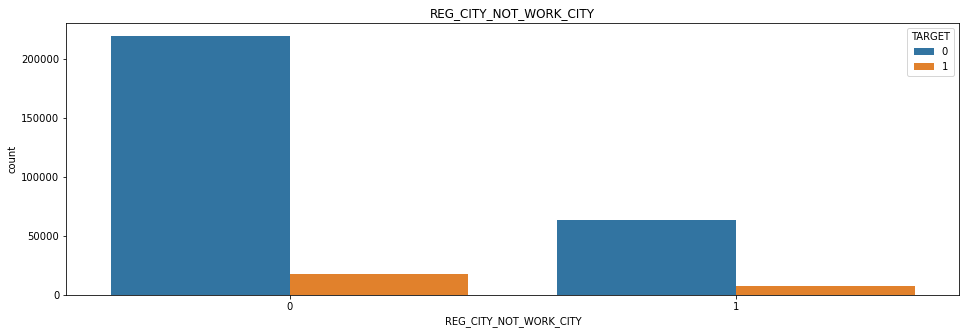

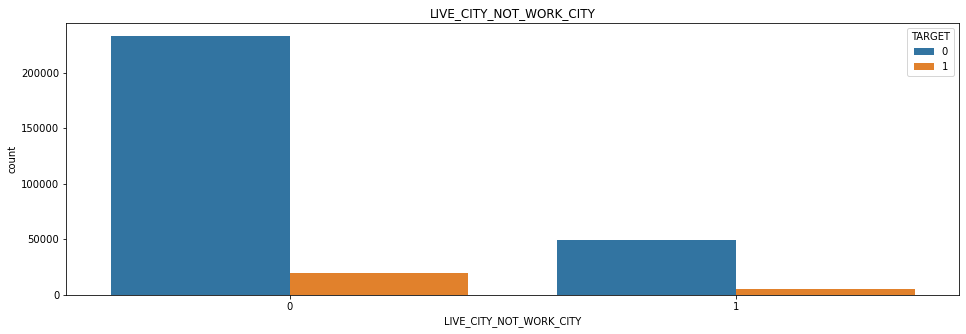

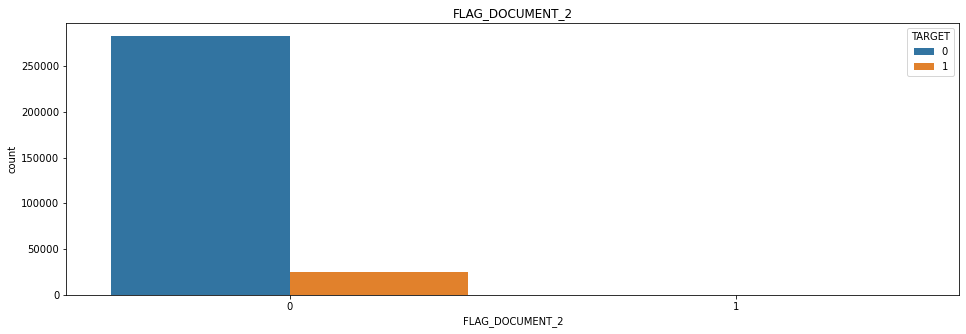

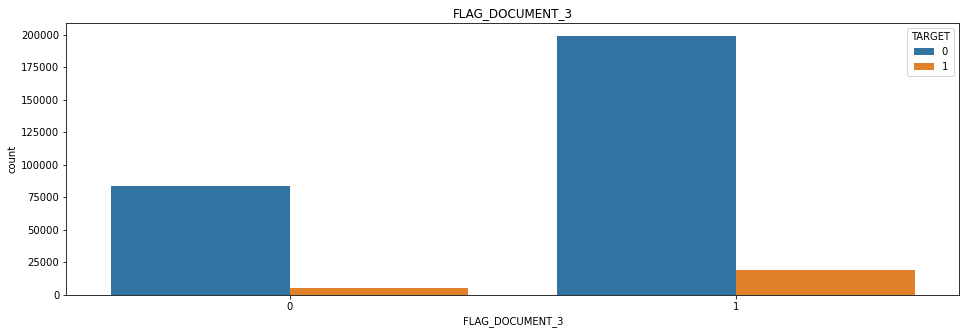

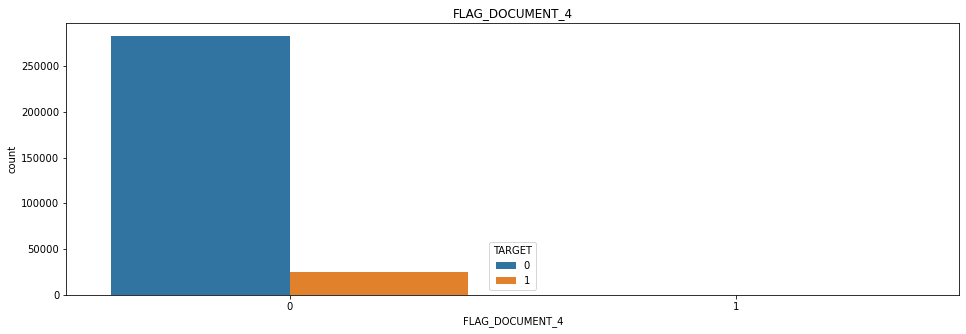

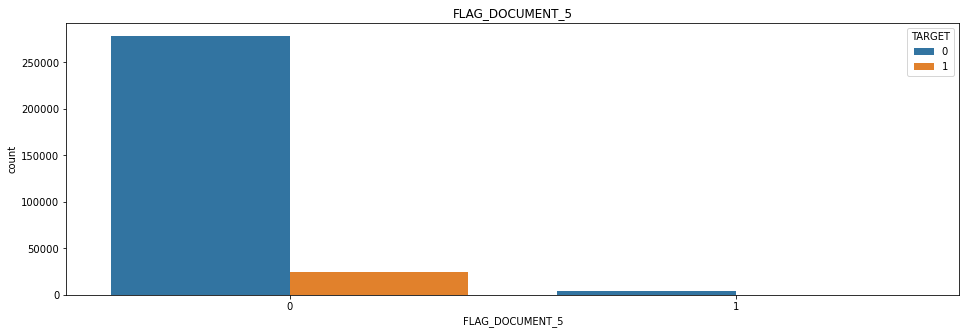

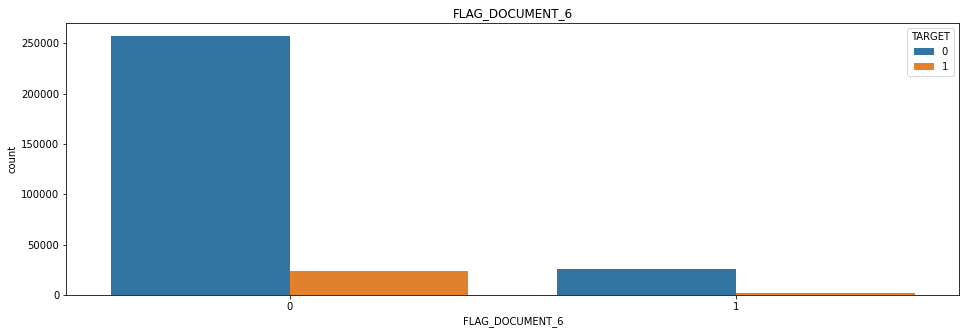

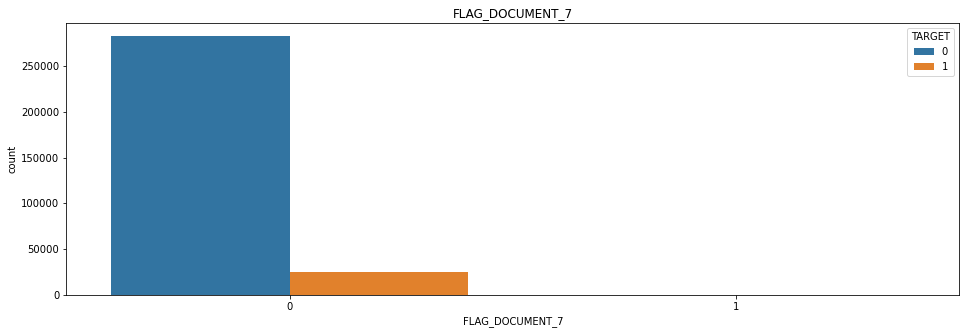

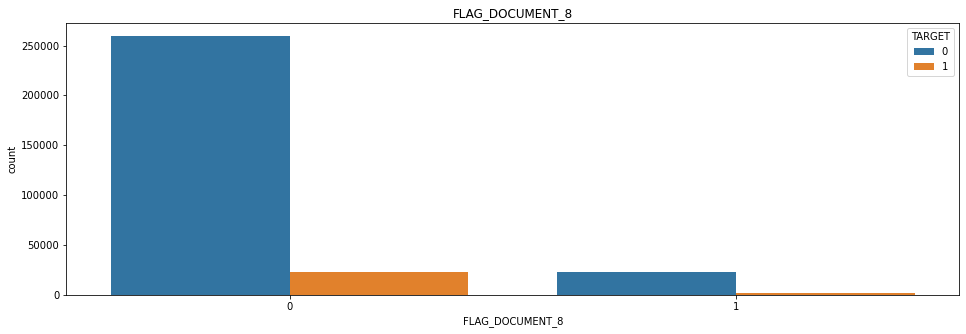

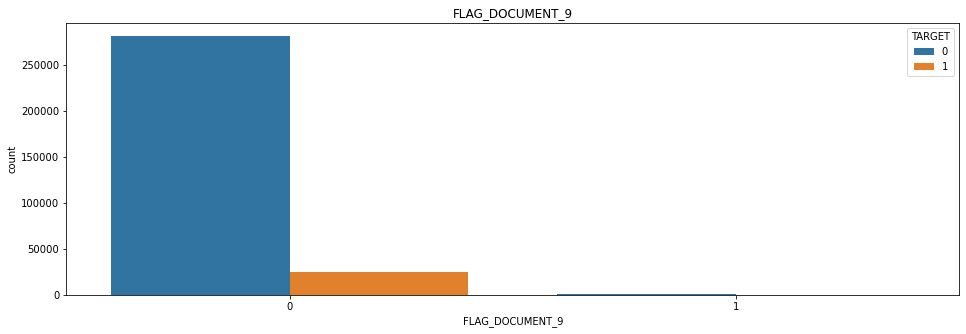

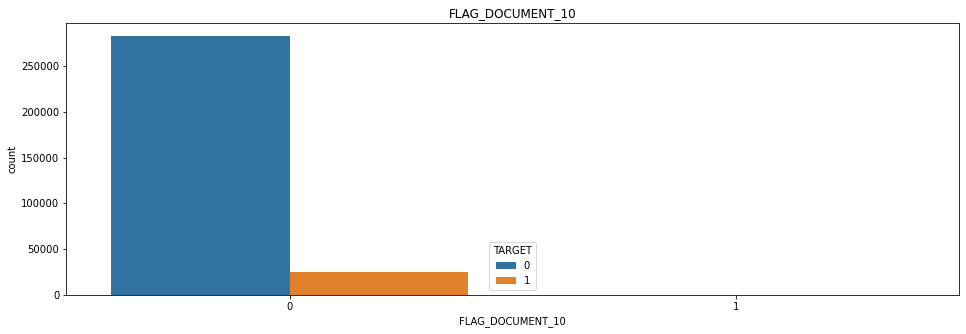

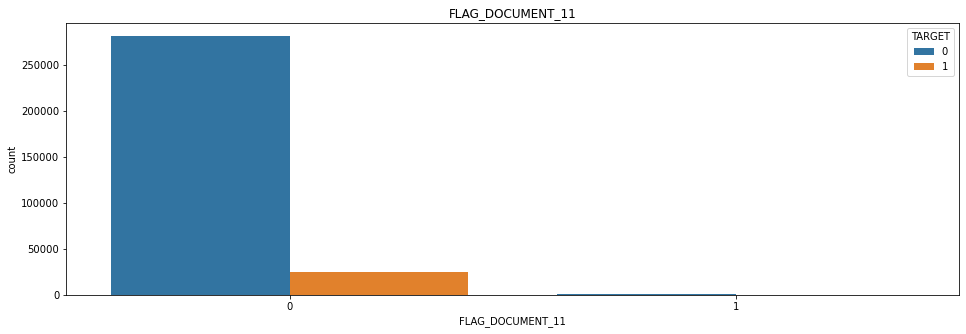

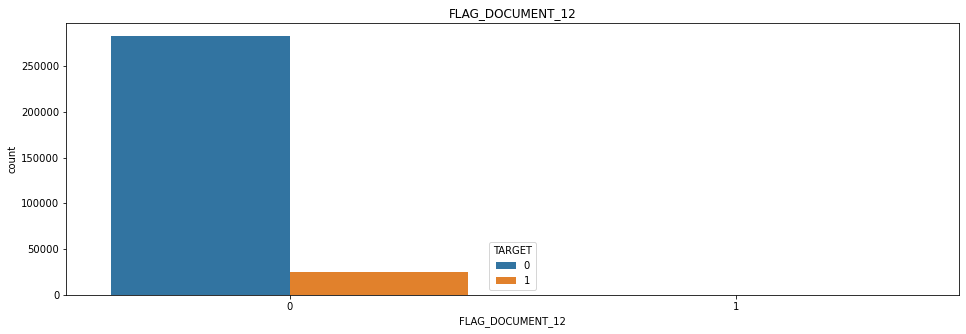

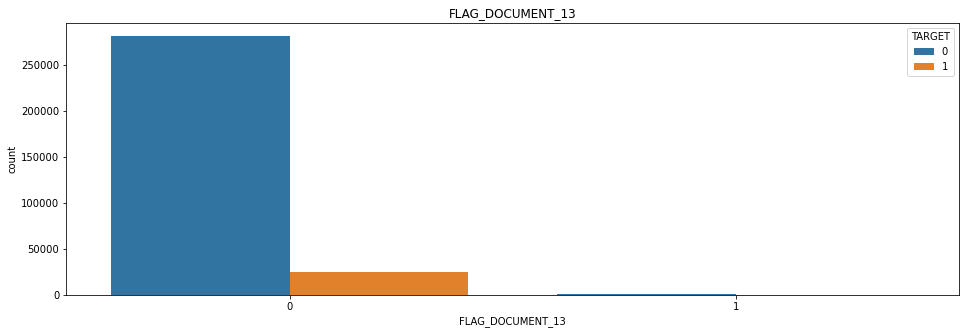

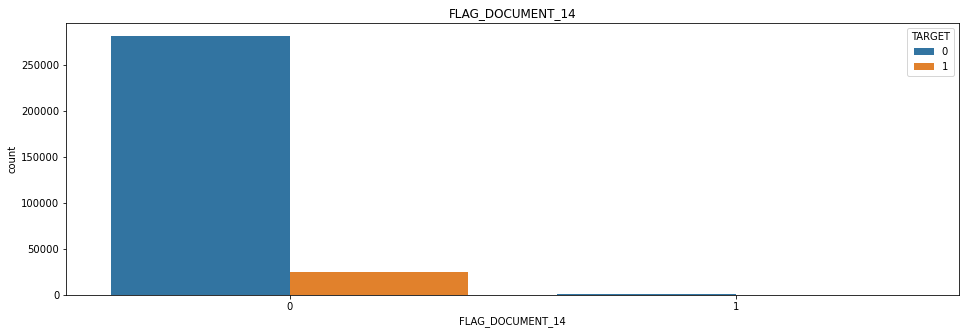

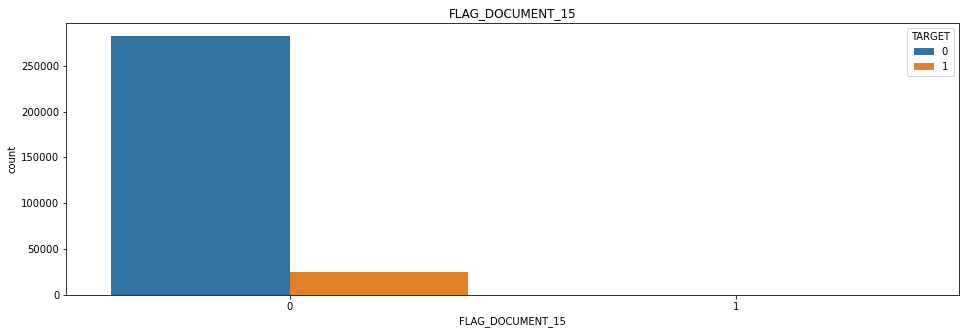

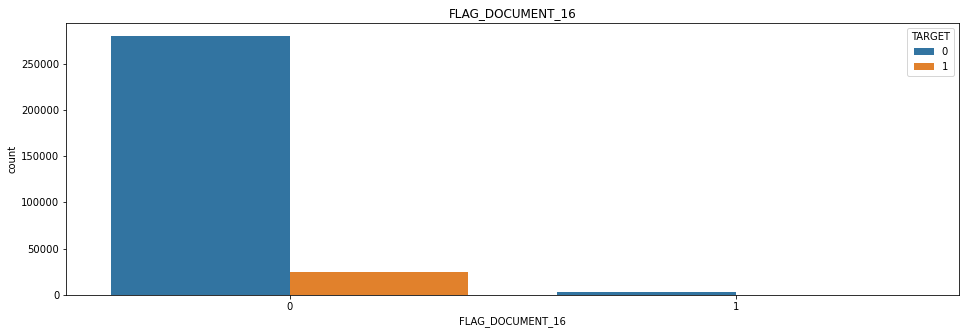

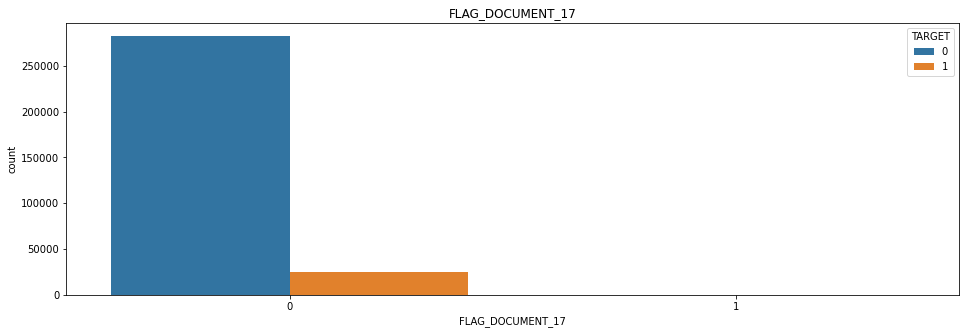

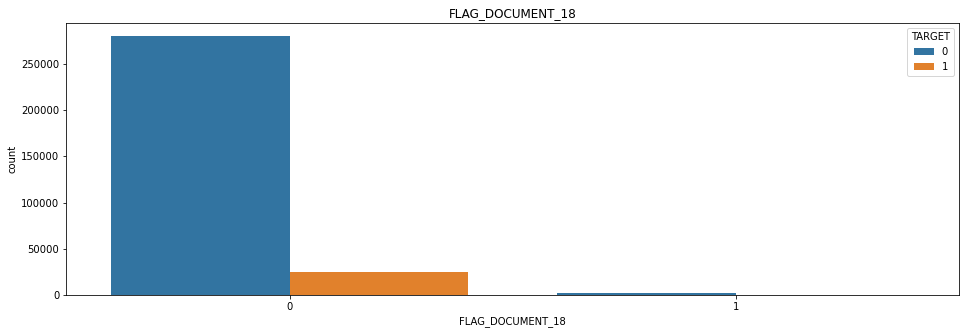

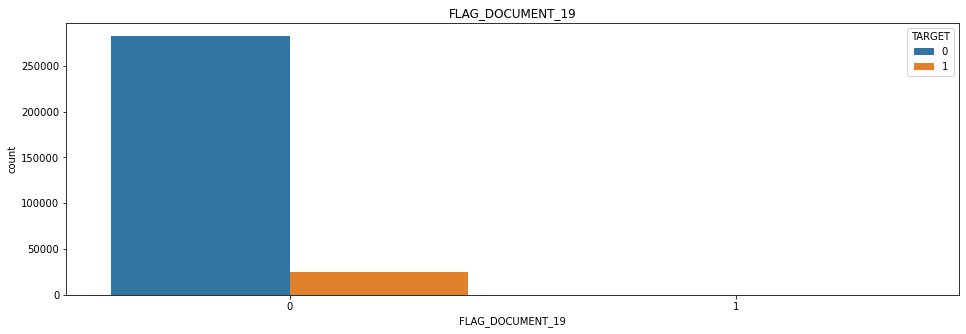

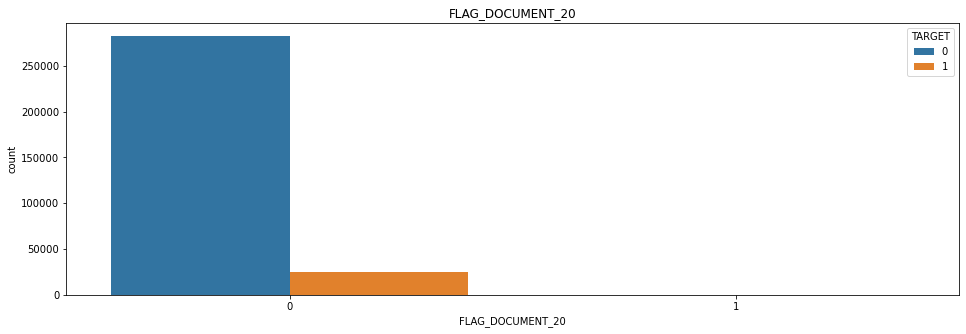

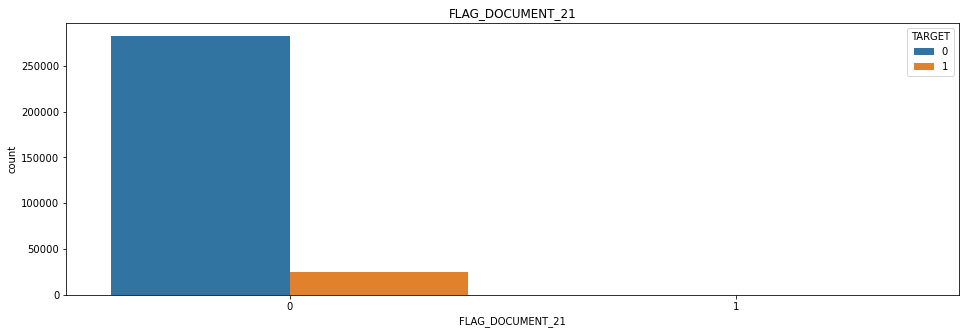

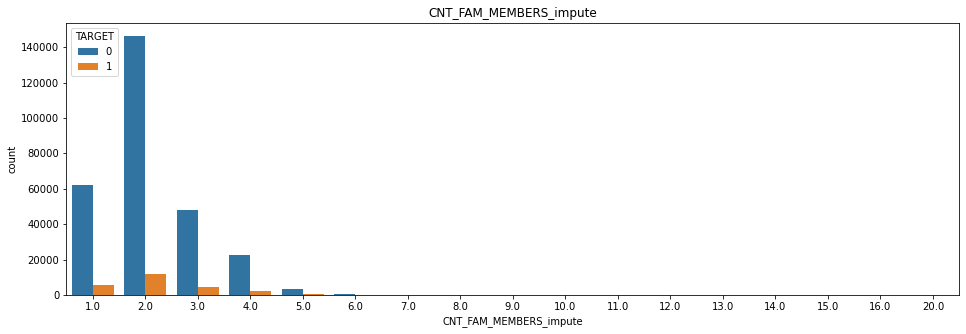

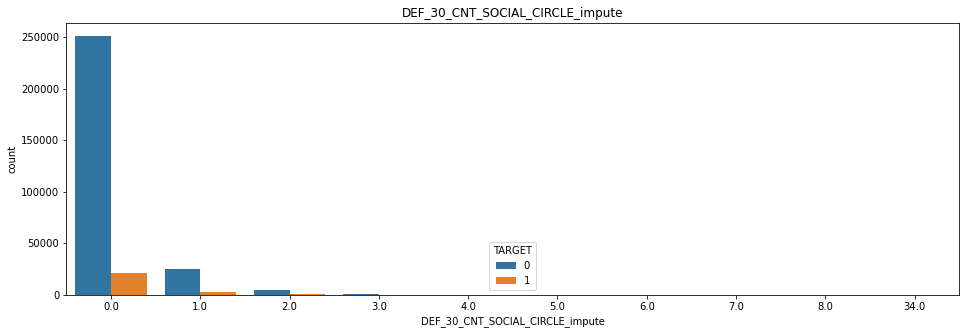

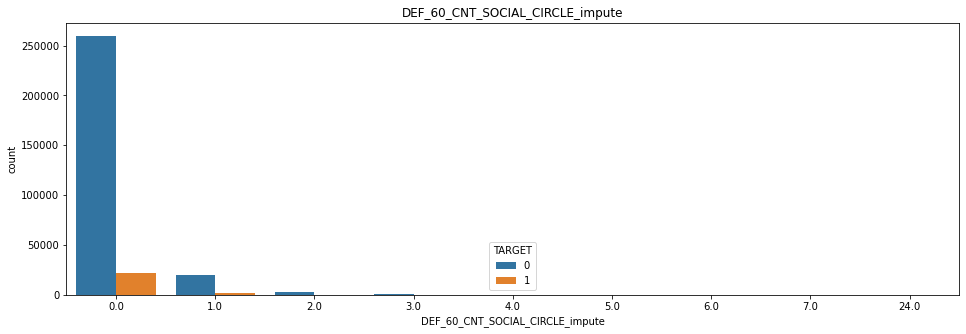

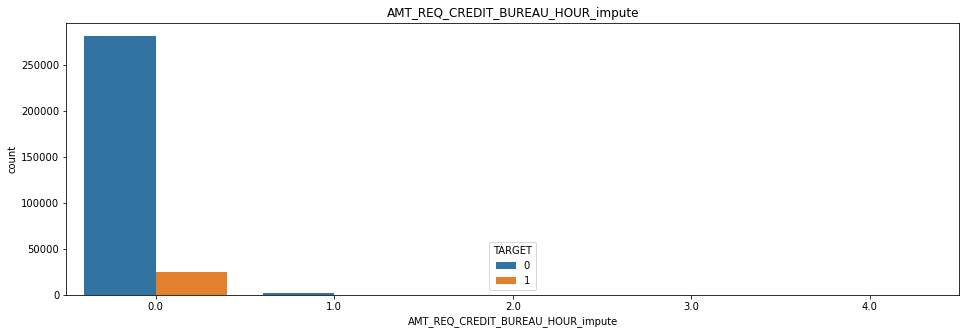

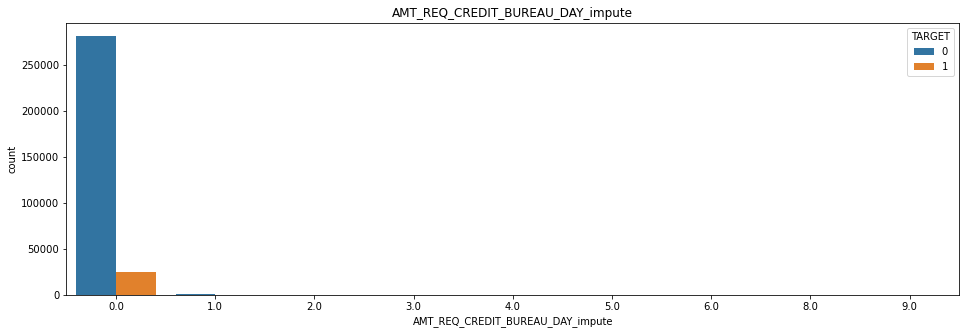

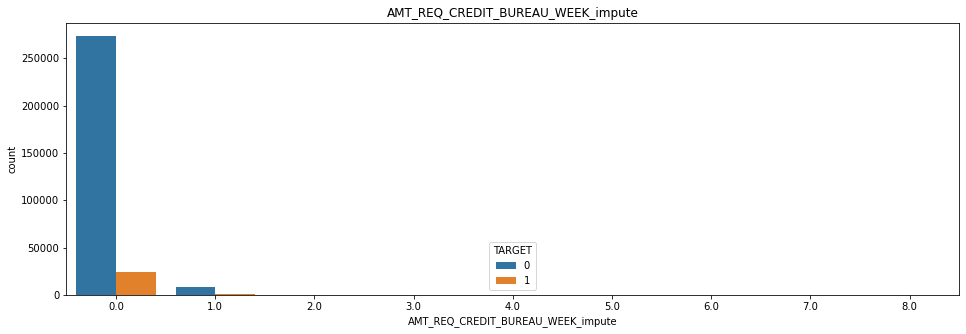

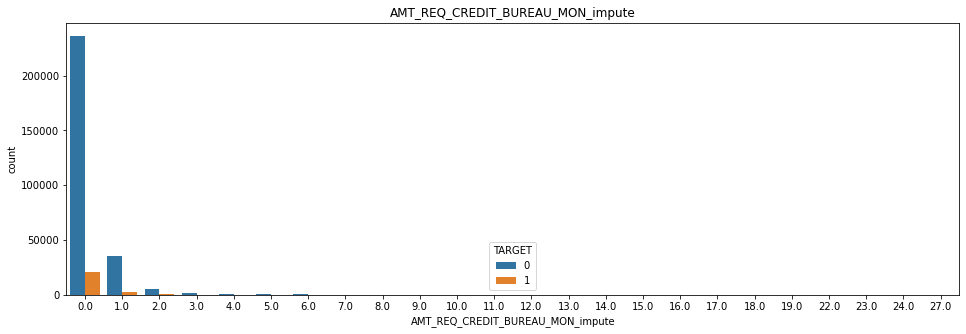

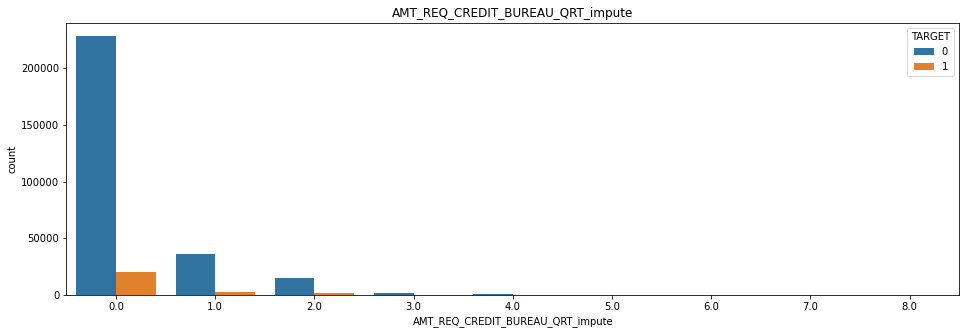

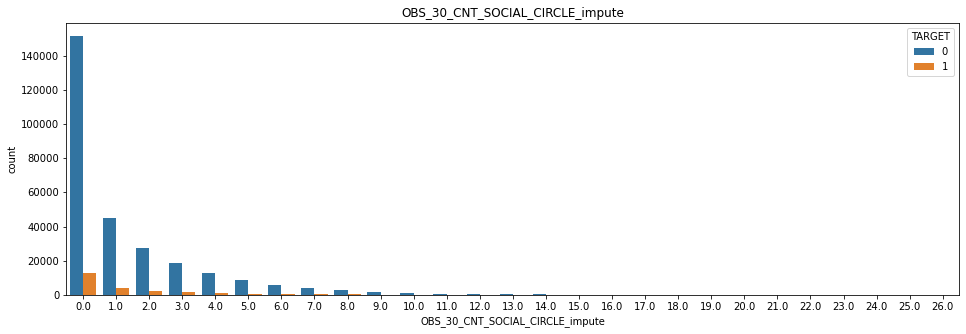

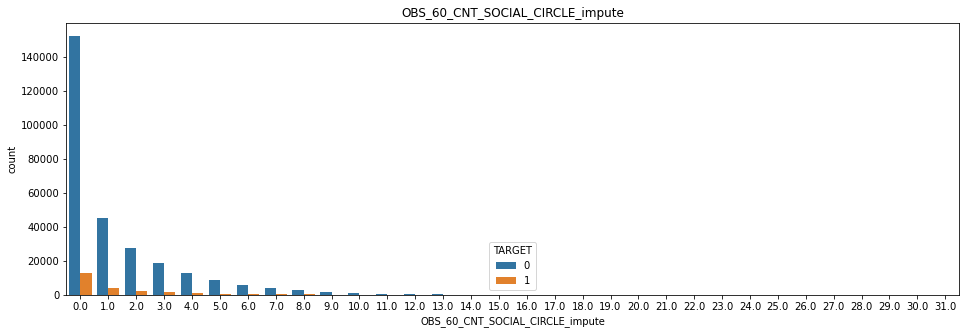

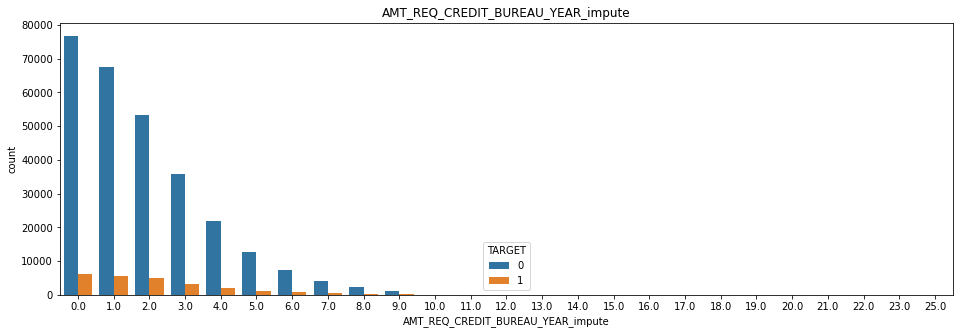

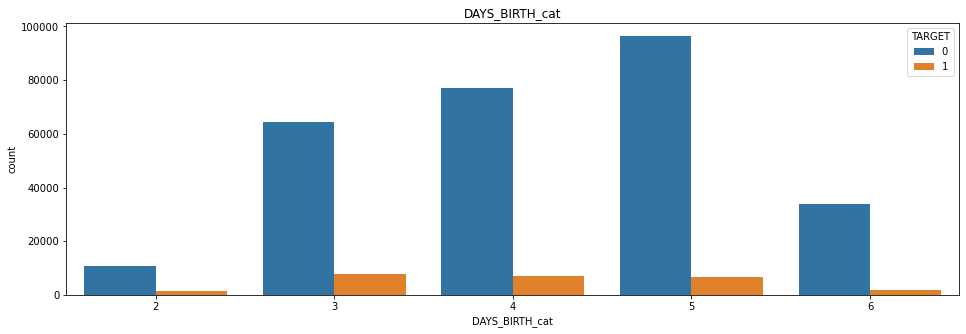

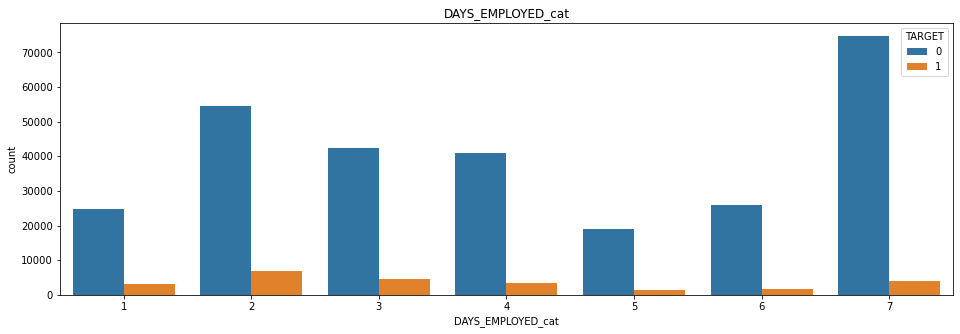

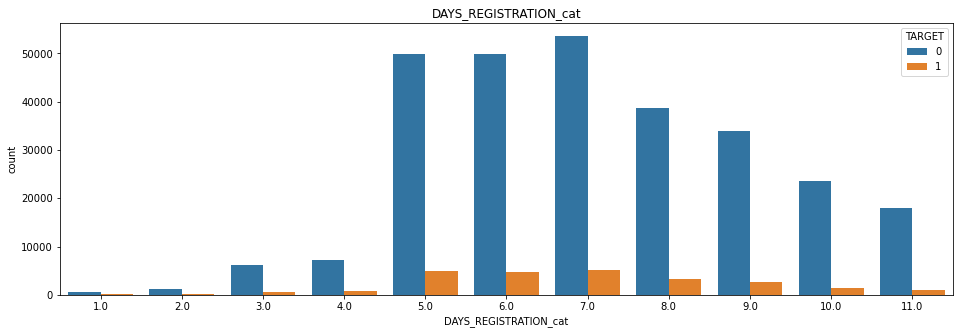

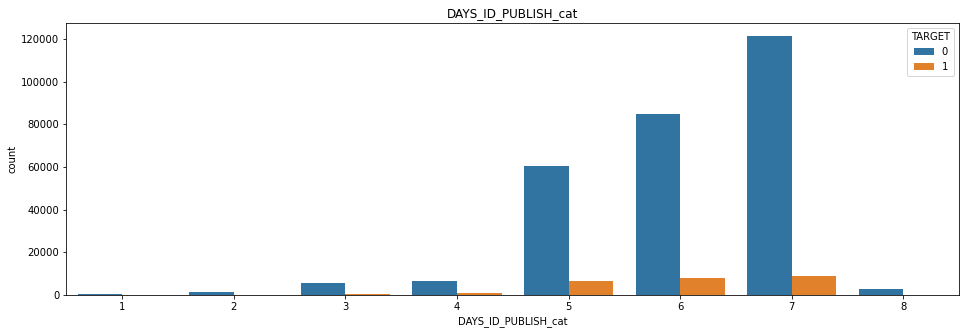

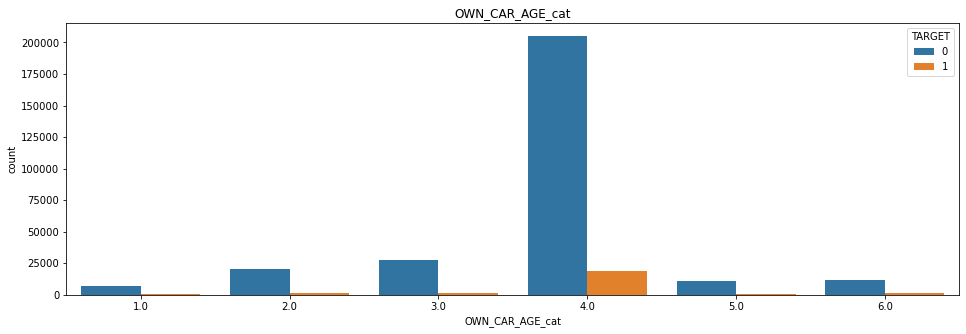

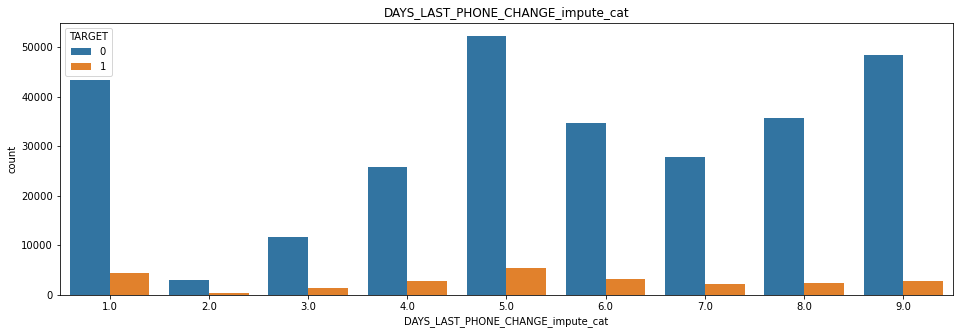

In [61]:
for col in expected_num_cat_cols:
    plt.figure(figsize=(16,5))
    sns.countplot(x=loan_df[col], hue=loan_df['TARGET'])
    plt.title(col)
    plt.show()

**Same as categorical features number of defaulters are increasing with total number of loans**

In [62]:
# Creating checkpoint
loan_df1 = loan_df.copy()

## 6. Encode the columns that is required for the model

In [63]:
with_2_cat_col = []
for col in cat_col:
    print(col)
    print(loan_df[col].unique())
    if(loan_df[col].unique().shape[0] == 2):
        with_2_cat_col.append(col)
    print("===================")

NAME_CONTRACT_TYPE
['Cash loans' 'Revolving loans']
CODE_GENDER
['M' 'F' 'XNA']
FLAG_OWN_CAR
['N' 'Y']
FLAG_OWN_REALTY
['Y' 'N']
NAME_TYPE_SUITE
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'Other_B'
 'Group of people']
NAME_INCOME_TYPE
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE
['Laborers' 'Core staff' 'Accountants' 'Managers' 'Sales staff' 'Drivers'
 'Waiters/barmen staff' 'Cleaning staff' 'Cooking staff'
 'Private service staff' 'High skill tech staff' 'Realty agents'
 'Medicine staff' 'Security staff' 'Low-skill 

**Applying 1 hot encoding in binomial categorial features**

In [64]:
enc_data = pd.get_dummies(loan_df[with_2_cat_col], drop_first=True)

In [65]:
loan_df = loan_df.join(enc_data)

In [66]:
# Droping with_2_cat_col cols from dataset
loan_df.drop(with_2_cat_col, axis=1, inplace=True)

In [67]:
cat_col = cat_col.drop(with_2_cat_col)

In [68]:
# CODE_GENDER has 3 values doing OHE
gender_en = pd.get_dummies(loan_df['CODE_GENDER'], drop_first=True)

In [69]:
loan_df = loan_df.join(gender_en)
loan_df.drop('CODE_GENDER',axis=1, inplace=True)

In [70]:
cat_col = cat_col.drop('CODE_GENDER')

In [71]:
binary_enc_col = ['NAME_TYPE_SUITE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE','FONDKAPREMONT_MODE']
label_enc_col = {'NAME_INCOME_TYPE': {'Student':0, 'Unemployed':1, 'Pensioner':2, 'Maternity leave':3, 'Working':4, 'Businessman':5,'State servant':6}
                 ,'NAME_EDUCATION_TYPE': {'Lower secondary':0, 'Secondary / secondary special':1, 'Academic degree':2, 'Incomplete higher':3, 'Higher education':4},
                 'HOUSETYPE_MODE': {'block of flats':0, 'terraced house':1, 'specific housing':2},
                 'WALLSMATERIAL_MODE': {'Stone, brick':0, 'Block':1, 'Panel':2, 'Mixed':3, 'Wooden':4, 'Others':5, 'Monolithic':6},
                 "WEEKDAY_APPR_PROCESS_START": {'MONDAY':0, 'TUESDAY':1, 'WEDNESDAY':2, 'THURSDAY':3, 'FRIDAY':4, 'SATURDAY': 5, 'SUNDAY':6}
                }

In [72]:
for col,val in label_enc_col.items():
    loan_df[col] = loan_df[col].map(val)

In [73]:
loan_df[label_enc_col].head()

,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START
0,4.0,1,0,0,2
1,6.0,4,0,1,0
2,4.0,1,0,2,0
3,4.0,1,0,2,2
4,4.0,1,0,2,3


In [74]:
from category_encoders.binary import BinaryEncoder

bi_en = BinaryEncoder()
bin_data = bi_en.fit_transform(loan_df[binary_enc_col])
bin_data.head()

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,NAME_TYPE_SUITE_0,NAME_TYPE_SUITE_1,NAME_TYPE_SUITE_2,NAME_TYPE_SUITE_3,NAME_FAMILY_STATUS_0,NAME_FAMILY_STATUS_1,NAME_FAMILY_STATUS_2,NAME_FAMILY_STATUS_3,NAME_HOUSING_TYPE_0,NAME_HOUSING_TYPE_1,...,ORGANIZATION_TYPE_0,ORGANIZATION_TYPE_1,ORGANIZATION_TYPE_2,ORGANIZATION_TYPE_3,ORGANIZATION_TYPE_4,ORGANIZATION_TYPE_5,ORGANIZATION_TYPE_6,FONDKAPREMONT_MODE_0,FONDKAPREMONT_MODE_1,FONDKAPREMONT_MODE_2
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


In [75]:
loan_df = loan_df.join(bin_data)

In [76]:
loan_df.drop(cat_col, axis=1, inplace=True)

In [77]:
loan_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 139 columns):
 #    Column                               Dtype  
---   ------                               -----  
 0    TARGET                               int64  
 1    CNT_CHILDREN                         int64  
 2    REGION_POPULATION_RELATIVE           float64
 3    FLAG_MOBIL                           int64  
 4    FLAG_EMP_PHONE                       int64  
 5    FLAG_WORK_PHONE                      int64  
 6    FLAG_CONT_MOBILE                     int64  
 7    FLAG_PHONE                           int64  
 8    FLAG_EMAIL                           int64  
 9    REGION_RATING_CLIENT                 int64  
 10   REGION_RATING_CLIENT_W_CITY          int64  
 11   HOUR_APPR_PROCESS_START              int64  
 12   REG_REGION_NOT_LIVE_REGION           int64  
 13   REG_REGION_NOT_WORK_REGION           int64  
 14   LIVE_REGION_NOT_WORK_REGION          int64  
 15   REG_CITY_NOT_LI

## ----------------- All Features are converted into Numbers --------------------

## 5. Plot the balanced data or imbalanced data

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


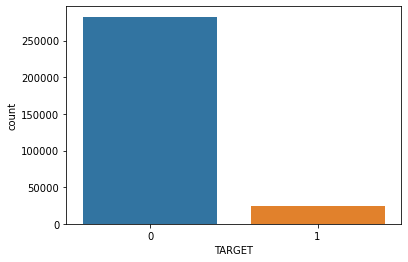

In [78]:
sns.countplot(loan_df['TARGET'])
plt.show()

## Applying Oversampling Technique SMOTE

## 4. Balance the dataset if the data is imbalanced

In [79]:
X = loan_df.drop('TARGET', axis=1)
y = loan_df['TARGET']

In [80]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'minority')
X_sm, y_sm = smote.fit_sample(X,y)

C:\Users\haris\anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


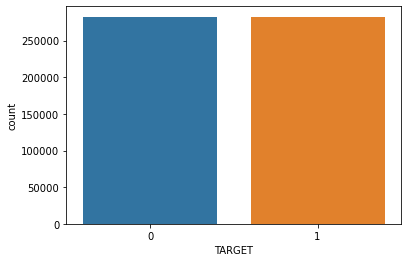

In [81]:
sns.countplot(y_sm)
plt.show()

### Saving the dataset

In [82]:
loan_df.to_csv('encoded_loan_df.csv')

**Normalizing the dataset**

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaler = scaler.fit_transform(X_sm)

In [84]:
df_scaler.shape

(565372, 138)

# Model Implementation

### Train Test Split

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(df_scaler, y_sm, random_state=343)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(424029, 138)
(424029,)
(141343, 138)
(141343,)


### Building ANN model

In [87]:
def buildANNModel(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers',1,3)):
        model.add(layers.Dense(units=hp.Int('units_'+str(i),min_value=100, max_value=500, step=20),
                              activation=hp.Choice('activation',['relu','selu','tanh']),
                              kernel_initializer="he_uniform"))
        model.add(layers.Dropout(hp.Choice('Dropout',[0.1,0.2,0.3])))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(
    hp.Choice('learning_rate', [0.0001])),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

### Keras Tuner to find best hyper parameters for model

In [88]:
tuner = RandomSearch(
    buildANNModel,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=2,
    directory='best hyper params',
    project_name='Bank Loan Application'
)

In [89]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 500, 'step': 20, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'tanh'], 'ordered': False}
Dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001], 'ordered': True}


In [91]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Trial 3 Complete [00h 56m 57s]
val_accuracy: 0.923802375793457

Best val_accuracy So Far: 0.923802375793457
Total elapsed time: 06h 54m 44s
INFO:tensorflow:Oracle triggered exit


In [92]:
tuner.results_summary()

Results summary
Results in best hyper params\Bank Loan Application
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 120
activation: tanh
Dropout: 0.1
learning_rate: 0.0001
units_1: 100
Score: 0.923802375793457
Trial summary
Hyperparameters:
num_layers: 1
units_0: 180
activation: relu
Dropout: 0.1
learning_rate: 0.0001
Score: 0.9217293858528137


In [93]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [94]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

### Adding EarlyStopping and ModelCheckpoint to monito and auto save best model

In [96]:
model = tuner.hypermodel.build(best_hps)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_loan_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.fit(X_train, y_train, epochs = 10000, validation_data = (X_test, y_test), callbacks=[es,mc])

Epoch 1/10000
13216/13251 [============================>.] - ETA: 0s - loss: 0.3310 - accuracy: 0.8623
Epoch 00001: val_accuracy improved from -inf to 0.88282, saving model to best_loan_model.h5
13251/13251 [==============================] - 18s 1ms/step - loss: 0.3309 - accuracy: 0.8624 - val_loss: 0.2923 - val_accuracy: 0.8828
Epoch 2/10000
13228/13251 [============================>.] - ETA: 0s - loss: 0.2911 - accuracy: 0.8826
Epoch 00002: val_accuracy improved from 0.88282 to 0.88924, saving model to best_loan_model.h5
13251/13251 [==============================] - 19s 1ms/step - loss: 0.2911 - accuracy: 0.8826 - val_loss: 0.2736 - val_accuracy: 0.8892
Epoch 3/10000
13250/13251 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.8878 ETA: 0s - los
Epoch 00003: val_accuracy improved from 0.88924 to 0.89267, saving model to best_loan_model.h5
13251/13251 [==============================] - 19s 1ms/step - loss: 0.2760 - accuracy: 0.8878 - val_loss: 0.2637 - val_accu

Epoch 26/10000
13245/13251 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9109
Epoch 00026: val_accuracy did not improve from 0.91401
13251/13251 [==============================] - 19s 1ms/step - loss: 0.2241 - accuracy: 0.9109 - val_loss: 0.2201 - val_accuracy: 0.9140
Epoch 27/10000
13248/13251 [============================>.] - ETA: 0s - loss: 0.2238 - accuracy: 0.9112
Epoch 00027: val_accuracy did not improve from 0.91401
13251/13251 [==============================] - 18s 1ms/step - loss: 0.2238 - accuracy: 0.9112 - val_loss: 0.2199 - val_accuracy: 0.9139
Epoch 28/10000
13223/13251 [============================>.] - ETA: 0s - loss: 0.2234 - accuracy: 0.9110
Epoch 00028: val_accuracy improved from 0.91401 to 0.91405, saving model to best_loan_model.h5
13251/13251 [==============================] - 19s 1ms/step - loss: 0.2233 - accuracy: 0.9110 - val_loss: 0.2191 - val_accuracy: 0.9141
Epoch 29/10000
13229/13251 [============================>.] - ETA: 0s - los

Epoch 52/10000
13205/13251 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9166
Epoch 00052: val_accuracy improved from 0.91887 to 0.91889, saving model to best_loan_model.h5
13251/13251 [==============================] - 19s 1ms/step - loss: 0.2108 - accuracy: 0.9166 - val_loss: 0.2109 - val_accuracy: 0.9189
Epoch 53/10000
13234/13251 [============================>.] - ETA: 0s - loss: 0.2104 - accuracy: 0.9171
Epoch 00053: val_accuracy improved from 0.91889 to 0.91938, saving model to best_loan_model.h5
13251/13251 [==============================] - 19s 1ms/step - loss: 0.2103 - accuracy: 0.9171 - val_loss: 0.2100 - val_accuracy: 0.9194
Epoch 54/10000
13239/13251 [============================>.] - ETA: 0s - loss: 0.2095 - accuracy: 0.9174
Epoch 00054: val_accuracy improved from 0.91938 to 0.91968, saving model to best_loan_model.h5
13251/13251 [==============================] - 19s 1ms/step - loss: 0.2095 - accuracy: 0.9174 - val_loss: 0.2100 - val_accuracy: 0.

Epoch 78/10000
13224/13251 [============================>.] - ETA: 0s - loss: 0.2021 - accuracy: 0.9205
Epoch 00078: val_accuracy did not improve from 0.92256
13251/13251 [==============================] - 20s 1ms/step - loss: 0.2020 - accuracy: 0.9205 - val_loss: 0.2045 - val_accuracy: 0.9222
Epoch 79/10000
13223/13251 [============================>.] - ETA: 0s - loss: 0.2018 - accuracy: 0.9209
Epoch 00079: val_accuracy did not improve from 0.92256
13251/13251 [==============================] - 22s 2ms/step - loss: 0.2018 - accuracy: 0.9208 - val_loss: 0.2045 - val_accuracy: 0.9218
Epoch 80/10000
13243/13251 [============================>.] - ETA: 0s - loss: 0.2014 - accuracy: 0.9210 ETA: 0s - l
Epoch 00080: val_accuracy did not improve from 0.92256
13251/13251 [==============================] - 21s 2ms/step - loss: 0.2015 - accuracy: 0.9210 - val_loss: 0.2047 - val_accuracy: 0.9219
Epoch 81/10000
13234/13251 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9205

Epoch 104/10000
13229/13251 [============================>.] - ETA: 0s - loss: 0.1971 - accuracy: 0.9228
Epoch 00104: val_accuracy did not improve from 0.92408
13251/13251 [==============================] - 21s 2ms/step - loss: 0.1972 - accuracy: 0.9228 - val_loss: 0.2020 - val_accuracy: 0.9237
Epoch 105/10000
13249/13251 [============================>.] - ETA: 0s - loss: 0.1966 - accuracy: 0.9233
Epoch 00105: val_accuracy did not improve from 0.92408
13251/13251 [==============================] - 20s 1ms/step - loss: 0.1966 - accuracy: 0.9233 - val_loss: 0.2019 - val_accuracy: 0.9241
Epoch 106/10000
13226/13251 [============================>.] - ETA: 0s - loss: 0.1965 - accuracy: 0.9234 ETA: 0s - loss: 0.196
Epoch 00106: val_accuracy improved from 0.92408 to 0.92410, saving model to best_loan_model.h5
13251/13251 [==============================] - 21s 2ms/step - loss: 0.1965 - accuracy: 0.9234 - val_loss: 0.2018 - val_accuracy: 0.9241
Epoch 107/10000
13211/13251 [=====================

13239/13251 [============================>.] - ETA: 0s - loss: 0.1938 - accuracy: 0.9244
Epoch 00130: val_accuracy improved from 0.92527 to 0.92528, saving model to best_loan_model.h5
13251/13251 [==============================] - 20s 2ms/step - loss: 0.1938 - accuracy: 0.9244 - val_loss: 0.2004 - val_accuracy: 0.9253
Epoch 131/10000
13244/13251 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9246
Epoch 00131: val_accuracy did not improve from 0.92528
13251/13251 [==============================] - 22s 2ms/step - loss: 0.1933 - accuracy: 0.9246 - val_loss: 0.2002 - val_accuracy: 0.9252
Epoch 132/10000
13231/13251 [============================>.] - ETA: 0s - loss: 0.1934 - accuracy: 0.9246
Epoch 00132: val_accuracy did not improve from 0.92528
13251/13251 [==============================] - 21s 2ms/step - loss: 0.1934 - accuracy: 0.9246 - val_loss: 0.2002 - val_accuracy: 0.9245
Epoch 133/10000
13248/13251 [============================>.] - ETA: 0s - loss: 0.1932 - 

Epoch 157/10000
13241/13251 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.9258
Epoch 00157: val_accuracy did not improve from 0.92596
13251/13251 [==============================] - 23s 2ms/step - loss: 0.1910 - accuracy: 0.9258 - val_loss: 0.1996 - val_accuracy: 0.9259
Epoch 158/10000
13234/13251 [============================>.] - ETA: 0s - loss: 0.1905 - accuracy: 0.9257
Epoch 00158: val_accuracy did not improve from 0.92596
13251/13251 [==============================] - 20s 2ms/step - loss: 0.1905 - accuracy: 0.9257 - val_loss: 0.1994 - val_accuracy: 0.9259
Epoch 159/10000
13243/13251 [============================>.] - ETA: 0s - loss: 0.1906 - accuracy: 0.9260
Epoch 00159: val_accuracy did not improve from 0.92596
13251/13251 [==============================] - 20s 1ms/step - loss: 0.1906 - accuracy: 0.9260 - val_loss: 0.1996 - val_accuracy: 0.9256
Epoch 160/10000
13225/13251 [============================>.] - ETA: 0s - loss: 0.1903 - accuracy: 0.9262
Epoch 0

13224/13251 [============================>.] - ETA: 0s - loss: 0.1883 - accuracy: 0.9266
Epoch 00184: val_accuracy did not improve from 0.92648
13251/13251 [==============================] - 21s 2ms/step - loss: 0.1883 - accuracy: 0.9266 - val_loss: 0.1989 - val_accuracy: 0.9263
Epoch 185/10000
13244/13251 [============================>.] - ETA: 0s - loss: 0.1888 - accuracy: 0.9267
Epoch 00185: val_accuracy did not improve from 0.92648
13251/13251 [==============================] - 21s 2ms/step - loss: 0.1888 - accuracy: 0.9267 - val_loss: 0.1992 - val_accuracy: 0.9257
Epoch 186/10000
13239/13251 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9266
Epoch 00186: val_accuracy did not improve from 0.92648
13251/13251 [==============================] - 21s 2ms/step - loss: 0.1887 - accuracy: 0.9266 - val_loss: 0.1997 - val_accuracy: 0.9259
Epoch 187/10000
13231/13251 [============================>.] - ETA: 0s - loss: 0.1884 - accuracy: 0.9269
Epoch 00187: val_accura

13209/13251 [============================>.] - ETA: 0s - loss: 0.1869 - accuracy: 0.9273
Epoch 00211: val_accuracy did not improve from 0.92689
13251/13251 [==============================] - 17s 1ms/step - loss: 0.1869 - accuracy: 0.9273 - val_loss: 0.1987 - val_accuracy: 0.9264
Epoch 212/10000
13239/13251 [============================>.] - ETA: 0s - loss: 0.1866 - accuracy: 0.9275
Epoch 00212: val_accuracy did not improve from 0.92689
13251/13251 [==============================] - 17s 1ms/step - loss: 0.1866 - accuracy: 0.9275 - val_loss: 0.1984 - val_accuracy: 0.9264
Epoch 213/10000
13243/13251 [============================>.] - ETA: 0s - loss: 0.1867 - accuracy: 0.9273
Epoch 00213: val_accuracy did not improve from 0.92689
13251/13251 [==============================] - 17s 1ms/step - loss: 0.1867 - accuracy: 0.9273 - val_loss: 0.1984 - val_accuracy: 0.9262
Epoch 214/10000
13206/13251 [============================>.] - ETA: 0s - loss: 0.1867 - accuracy: 0.9277
Epoch 00214: val_accura

13248/13251 [============================>.] - ETA: 0s - loss: 0.1855 - accuracy: 0.9281
Epoch 00238: val_accuracy did not improve from 0.92721
13251/13251 [==============================] - 18s 1ms/step - loss: 0.1855 - accuracy: 0.9281 - val_loss: 0.1983 - val_accuracy: 0.9264
Epoch 239/10000
13210/13251 [============================>.] - ETA: 0s - loss: 0.1852 - accuracy: 0.9284
Epoch 00239: val_accuracy did not improve from 0.92721
13251/13251 [==============================] - 17s 1ms/step - loss: 0.1852 - accuracy: 0.9284 - val_loss: 0.1986 - val_accuracy: 0.9266
Epoch 240/10000
13205/13251 [============================>.] - ETA: 0s - loss: 0.1850 - accuracy: 0.9281
Epoch 00240: val_accuracy did not improve from 0.92721
13251/13251 [==============================] - 17s 1ms/step - loss: 0.1850 - accuracy: 0.9281 - val_loss: 0.1982 - val_accuracy: 0.9268
Epoch 241/10000
13226/13251 [============================>.] - ETA: 0s - loss: 0.1850 - accuracy: 0.9281
Epoch 00241: val_accura

13250/13251 [============================>.] - ETA: 0s - loss: 0.1843 - accuracy: 0.9285
Epoch 00265: val_accuracy improved from 0.92745 to 0.92754, saving model to best_loan_model.h5
13251/13251 [==============================] - 18s 1ms/step - loss: 0.1843 - accuracy: 0.9285 - val_loss: 0.1980 - val_accuracy: 0.9275
Epoch 266/10000
13246/13251 [============================>.] - ETA: 0s - loss: 0.1840 - accuracy: 0.9283
Epoch 00266: val_accuracy did not improve from 0.92754
13251/13251 [==============================] - 16s 1ms/step - loss: 0.1840 - accuracy: 0.9283 - val_loss: 0.1984 - val_accuracy: 0.9269
Epoch 267/10000
13235/13251 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9290
Epoch 00267: val_accuracy did not improve from 0.92754
13251/13251 [==============================] - 16s 1ms/step - loss: 0.1840 - accuracy: 0.9290 - val_loss: 0.1993 - val_accuracy: 0.9269
Epoch 268/10000
13223/13251 [============================>.] - ETA: 0s - loss: 0.1839 - 

13237/13251 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9293
Epoch 00292: val_accuracy did not improve from 0.92754
13251/13251 [==============================] - 18s 1ms/step - loss: 0.1830 - accuracy: 0.9293 - val_loss: 0.1982 - val_accuracy: 0.9270
Epoch 293/10000
13233/13251 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9287
Epoch 00293: val_accuracy did not improve from 0.92754
13251/13251 [==============================] - 16s 1ms/step - loss: 0.1829 - accuracy: 0.9287 - val_loss: 0.1982 - val_accuracy: 0.9267
Epoch 294/10000
13242/13251 [============================>.] - ETA: 0s - loss: 0.1826 - accuracy: 0.9291
Epoch 00294: val_accuracy did not improve from 0.92754
13251/13251 [==============================] - 17s 1ms/step - loss: 0.1825 - accuracy: 0.9291 - val_loss: 0.1978 - val_accuracy: 0.9269
Epoch 295/10000
13241/13251 [============================>.] - ETA: 0s - loss: 0.1831 - accuracy: 0.9289 ETA: 0s - loss: 0.1832 

13213/13251 [============================>.] - ETA: 0s - loss: 0.1818 - accuracy: 0.9298 ETA: 0s - loss: 0.181
Epoch 00319: val_accuracy did not improve from 0.92754
13251/13251 [==============================] - 18s 1ms/step - loss: 0.1818 - accuracy: 0.9297 - val_loss: 0.1980 - val_accuracy: 0.9270
Epoch 320/10000
13246/13251 [============================>.] - ETA: 0s - loss: 0.1824 - accuracy: 0.9293 ETA: 0s - loss: 0.1825 - accuracy
Epoch 00320: val_accuracy did not improve from 0.92754
13251/13251 [==============================] - 18s 1ms/step - loss: 0.1824 - accuracy: 0.9293 - val_loss: 0.1977 - val_accuracy: 0.9271
Epoch 321/10000
13211/13251 [============================>.] - ETA: 0s - loss: 0.1818 - accuracy: 0.9294
Epoch 00321: val_accuracy did not improve from 0.92754
13251/13251 [==============================] - 17s 1ms/step - loss: 0.1819 - accuracy: 0.9294 - val_loss: 0.1984 - val_accuracy: 0.9273
Epoch 322/10000
13229/13251 [============================>.] - ETA: 0s -

13207/13251 [============================>.] - ETA: 0s - loss: 0.1811 - accuracy: 0.9294
Epoch 00346: val_accuracy did not improve from 0.92755
13251/13251 [==============================] - 16s 1ms/step - loss: 0.1812 - accuracy: 0.9294 - val_loss: 0.1975 - val_accuracy: 0.9268
Epoch 347/10000
13238/13251 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9301
Epoch 00347: val_accuracy did not improve from 0.92755
13251/13251 [==============================] - 16s 1ms/step - loss: 0.1805 - accuracy: 0.9302 - val_loss: 0.1977 - val_accuracy: 0.9274
Epoch 348/10000
13207/13251 [============================>.] - ETA: 0s - loss: 0.1816 - accuracy: 0.9298
Epoch 00348: val_accuracy did not improve from 0.92755
13251/13251 [==============================] - 15s 1ms/step - loss: 0.1816 - accuracy: 0.9298 - val_loss: 0.1978 - val_accuracy: 0.9275
Epoch 349/10000
13239/13251 [============================>.] - ETA: 0s - loss: 0.1807 - accuracy: 0.9301
Epoch 00349: val_accura

13246/13251 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9297
Epoch 00373: val_accuracy did not improve from 0.92781
13251/13251 [==============================] - 16s 1ms/step - loss: 0.1805 - accuracy: 0.9297 - val_loss: 0.1976 - val_accuracy: 0.9273
Epoch 374/10000
13211/13251 [============================>.] - ETA: 0s - loss: 0.1806 - accuracy: 0.9300
Epoch 00374: val_accuracy did not improve from 0.92781
13251/13251 [==============================] - 15s 1ms/step - loss: 0.1806 - accuracy: 0.9300 - val_loss: 0.1982 - val_accuracy: 0.9272
Epoch 375/10000
13248/13251 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9306
Epoch 00375: val_accuracy did not improve from 0.92781
13251/13251 [==============================] - 16s 1ms/step - loss: 0.1802 - accuracy: 0.9306 - val_loss: 0.1976 - val_accuracy: 0.9274
Epoch 376/10000
13249/13251 [============================>.] - ETA: 0s - loss: 0.1796 - accuracy: 0.9306
Epoch 00376: val_accura

13232/13251 [============================>.] - ETA: 0s - loss: 0.1796 - accuracy: 0.9305
Epoch 00400: val_accuracy did not improve from 0.92816
13251/13251 [==============================] - 18s 1ms/step - loss: 0.1796 - accuracy: 0.9305 - val_loss: 0.1972 - val_accuracy: 0.9274
Epoch 401/10000
13238/13251 [============================>.] - ETA: 0s - loss: 0.1795 - accuracy: 0.9305
Epoch 00401: val_accuracy did not improve from 0.92816
13251/13251 [==============================] - 18s 1ms/step - loss: 0.1794 - accuracy: 0.9305 - val_loss: 0.1978 - val_accuracy: 0.9277
Epoch 402/10000
13210/13251 [============================>.] - ETA: 0s - loss: 0.1793 - accuracy: 0.9310
Epoch 00402: val_accuracy did not improve from 0.92816
13251/13251 [==============================] - 18s 1ms/step - loss: 0.1793 - accuracy: 0.9310 - val_loss: 0.1977 - val_accuracy: 0.9272
Epoch 403/10000
13230/13251 [============================>.] - ETA: 0s - loss: 0.1798 - accuracy: 0.9306
Epoch 00403: val_accura

Epoch 428/10000
13216/13251 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9310
Epoch 00428: val_accuracy did not improve from 0.92816
13251/13251 [==============================] - 20s 2ms/step - loss: 0.1785 - accuracy: 0.9310 - val_loss: 0.1972 - val_accuracy: 0.9277
Epoch 429/10000
13231/13251 [============================>.] - ETA: 0s - loss: 0.1791 - accuracy: 0.9304
Epoch 00429: val_accuracy did not improve from 0.92816
13251/13251 [==============================] - 19s 1ms/step - loss: 0.1791 - accuracy: 0.9304 - val_loss: 0.1975 - val_accuracy: 0.9277
Epoch 430/10000
13237/13251 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9310
Epoch 00430: val_accuracy did not improve from 0.92816
13251/13251 [==============================] - 18s 1ms/step - loss: 0.1787 - accuracy: 0.9310 - val_loss: 0.1981 - val_accuracy: 0.9270
Epoch 431/10000
13224/13251 [============================>.] - ETA: 0s - loss: 0.1783 - accuracy: 0.9308
Epoch 0

# Model Evaluation

### Predicting values based on test dataset

In [180]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [152]:
y_pred = model.predict_proba(X_test)
y_pred

Instructions for updating:
Please use `model.predict()` instead.


array([[0.3403371 ],
       [0.99998814],
       [0.19064683],
       ...,
       [0.0640505 ],
       [0.06653035],
       [0.05811149]], dtype=float32)

As we can see the predicted results are the probability so the results are laying between 0-1 we can set a threshold to convert these results into binary 0 or 1

In [153]:
threshold = 0.5

y_pred_binary = np.where(y_pred >= threshold, 1 , 0)
y_pred_binary

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [154]:
cm = confusion_matrix(y_test, y_pred_binary)
cm

array([[68185,  2456],
       [ 7807, 62895]], dtype=int64)

In [189]:
# Converting confusion metrics into TP,TN,FP,FN
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp

(68185, 2456, 7807, 62895)

As we can see in confusion matrix model has predicted 68185 TP, 2456 TN, 7807 FP, 62895 FN with 0.5 threshold we can decrease the threshold value it will increase the risk factor and prediction accuracy

# 7. Sensitivity Analysis and Specificity Analysis with 0.5 threshold

## Calculating the accuracy of the model

In [155]:
total = sum(sum(cm))
# Accuracy is total correct prediction / total prediction
# (TP+FN) / (TP+TN+FN+FP)
accuracy = (cm[0,0]+cm[1,1])/total
print(f"model accuracy is : {accuracy*100}% with 0.5 threshold")

model accuracy is : 92.73894002532845% with 0.5 threshold


**Or we can use sklearn accuracy_score function**

In [183]:
print(f"model accuracy is : {accuracy_score(y_test, y_pred_binary)*100}% with 0.5 threshold")

model accuracy is : 92.73894002532845% with 0.5 threshold


## Sensitivity Analysis

Sensitivity (aka Recall) means “out of all actual Positives, how many did we predict as Positive”, which can be explained as:
Sensitivity (Recall) = TP / (FN + TP)

In [190]:
sensitivity = tp / (tp + fn)
print(f"Model sensitivity is {sensitivity}")

Model sensitivity is 0.8895787955079064


## Specificity Analysis

Specificity (aka Selectivity or True Negative Rate, TNR) means “out of all actual Negatives, how many did we predict as Negative”, and can be written as:
Specificity = TN / (TN + FP)

In [192]:
specificity = tn / (tn + fp)
print(f"Model specificity is {specificity}")

Model specificity is 0.9652326552568622


# Sensitivity Analysis and Specificity Analysis with 0.8 threshold

In [158]:
threshold = 0.8

y_pred_binary1 = np.where(y_pred >= threshold, 1 , 0)
y_pred_binary1
cm1 = confusion_matrix(y_test, y_pred_binary1)
cm1

array([[70055,   586],
       [11346, 59356]], dtype=int64)

In [194]:
# Converting confusion metrics into TP,TN,FP,FN
tn, fp, fn, tp = cm1.ravel()
tn, fp, fn, tp

(70055, 586, 11346, 59356)

In [184]:
print(f"model accuracy is : {accuracy_score(y_test, y_pred_binary1)*100}% with 0.8 threshold")

model accuracy is : 91.55812456223514% with 0.8 threshold


In [195]:
# Sensitivity is TP / (TP+TN)

sensitivity1 = tp / (tp + fn)
print(f"Model sensitivity is {sensitivity1}")

Model sensitivity is 0.8395236344092105


## Specificity Analysis

In [196]:
# Specificity is FN / (FN+FP)

specificity1 = tn / (tn + fp)
print(f"Model specificity is {specificity1}")

Model specificity is 0.9917045341940233


As we can see by increasing the threshold specificity is increased but sensitivity is decreased 

## 8. Calculating area under ROC courve

The ROC curve is a useful tool for a few reasons:

1. The curves of different models can be compared directly in general or for different thresholds.
2. The area under the curve (AUC) can be used as a summary of the model skill.

We can utilize the ROC curve to visualize the overlap between the positive and negative classes. To do this, we can follow these steps:
1. Set the classification threshold at 0, which means all predictions are classified as Class 1 (Positive).
2. Calculate sensitivity and 1 — specificity for this threshold.
3. Plot the values (x = 1 — specificity, y = sensitivity).
4. Increase the classification threshold for a small number (like 0.005).
5. Repeat steps 1–4.
6. Repeat until the threshold is equal to 1 (which means all predictions are Class 0, Negative).

The result of this process will look like this graph. The area under the curve (AUC) is another evaluation metric that we can use for classification models. The 45 degree line is the baseline for which the AUC is 0.5. The perfect model will have an AUC of 1.0. The closer the AUC to 1.0, the better the predictions.

**Or we can use sklearn roc_auc_curve function it will return false positive rates, true positive rates and thresholds internally follow the above mentioned technique**

In [197]:
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score

In [198]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [199]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99917895, 0.99917895,
        1.        ]),
 array([0.00000000e+00, 2.82877429e-05, 1.13150972e-04, ...,
        9.99985856e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.9999993e+00, 9.9999928e-01, 9.9999911e-01, ..., 5.6999922e-04,
        5.6847930e-04, 1.2122129e-04], dtype=float32))

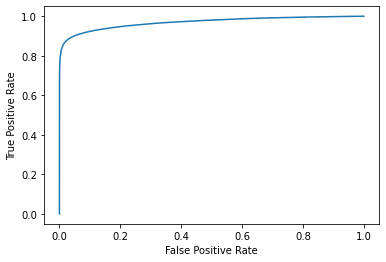

In [200]:
plt.plot(fpr, tpr)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
# plt.legend()
# show the plot
plt.show()

## AUC-ROC score

In [202]:
print(f"Area under the ROC curve : ",roc_auc_score(y_test, y_pred))

Area under the ROC curve :  0.9689031250506073
